In [2]:
import pandas as pd
import numpy as np
from pathlib import Path
import os 
from datetime import timedelta
import os
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, accuracy_score, confusion_matrix, r2_score
from sklearn.metrics import log_loss,auc,classification_report,roc_auc_score, roc_curve
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, label_binarize
from sklearn import tree
import graphviz

from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestClassifier


pd.set_option('display.max_columns', None)
%matplotlib inline

In [3]:
import sys
sys.path.append("..")
from ICM_utils import helper, evaluation, metrics

/home/ppop/miniconda3/envs/ICM/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## 1. Amelia and MICE imputed dataset using no censoring (full data)
* Amelia takes precedence
* Some pre-processing
* Need to run the model on 
    - missing data dataset 
    - GBM only dataset
    - standardized imputed no preprocessing dataset


# Gower distance example 

In [4]:
X2 = np.array([['Syria', 1200, 0,411114.44,True],
                  ['Ireland', 300, 0, 199393333.22, False],
                  ['United Kingdom', 100, 0, 32323222.121, False]], dtype=object)
               
Y2 = np.array([['United Kingdom', 200, 0, 99923921.47, True]], dtype=object)


D = metrics.gower_distances(X2,Y2)

print(D)

[[0.48183998]
 [0.51816   ]
 [0.28612828]]


../ICM_utils/metrics.py:148: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(categorical_features.dtype, np.int):


In [5]:
# Will work by comparing if an instance of X_train has the same form as something similar to X2. 
# Works with NaN values
# We have to define what X_train and Y_train is
#k = 3
#model = KNeighborsClassifier(n_neighbors=k,metric=metrics.gower_distances)
#model.fit(X_train,Y_train)

In [6]:
IMC_basedir = os.getcwd().split('code')[0]
DATA_Amelia_FILE = os.path.join(IMC_basedir, 'data/imputed_dataset_no_censoring_26022018_Amelia1.csv')
DATA_MICE_FILE = os.path.join(IMC_basedir, 'data/imputed_dataset_no_censoring_26022018_MICE.csv')
TRAIN_FILE = os.path.join(IMC_basedir, 'data/amelia_train')
TEST_FILE = os.path.join(IMC_basedir, 'data/amelia_test')
MODEL_DIR = os.path.join(IMC_basedir, 'data/amelia_model')

In [7]:
df_amelia = pd.read_csv(DATA_Amelia_FILE)
df_mice = pd.read_csv(DATA_MICE_FILE)

In [8]:
df_amelia.drop("Unnamed: 0", axis = 1, inplace=True)
df_mice.drop("Unnamed: 0", axis = 1, inplace=True)

In [9]:
df_amelia.head(2)

,Gender,Tumor_type,Tumor_grade,Gene_P53,Gene_Mgmt,Gene_Egfr,Gene_Mdm2,Gene_Cdk4,Gene_P16,Gene_Ihc_Atrx,Gene_Ch10Q,Gene_Ch9P,Tumor_Location,Tumor_Position,Surgery_type,Age_surgery,life_expectancy,IDH,TERT,IDH_TERT,X1p19q_codel,IK
0,M,gliome,3,NC,METHYLE,NORMAL,NORMAL,NORMAL,DELETE,Maintien,PERTE,NON PERTE,A,G,partielle,42,30,mutant,wt,3,0,90.512838
1,M,astrocytome,2,NC,NON METHYLE,NORMAL,NORMAL,NORMAL,NORMAL,extinction,NON PERTE,NON PERTE,N,non précisé,exérèse,28,2069,NC,wt,2,0,90.596534


In [10]:
df_amelia.shape

(2086, 22)

In [11]:
# Check for null values - no need here thanks to Alex and Amelia with its mouse
#for col in df_mice.columns:
 #   print('{0}\n  {1}\n'.format(col,df_mice[col].isnull().value_counts()))
# df_1 = df_small.dropna(axis=0, how='any')    

(array([1.572e+03, 2.490e+02, 1.330e+02, 5.900e+01, 3.500e+01, 1.500e+01,
        1.200e+01, 6.000e+00, 4.000e+00, 1.000e+00]),
 array([1.00000e+00, 1.16890e+03, 2.33680e+03, 3.50470e+03, 4.67260e+03,
        5.84050e+03, 7.00840e+03, 8.17630e+03, 9.34420e+03, 1.05121e+04,
        1.16800e+04]),
 <a list of 10 Patch objects>)

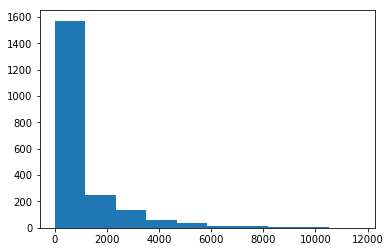

In [12]:
plt.hist(df_amelia.life_expectancy,bins =10)

## Split the predictor into multiple classes
* 3 classes 
* 12 classes
* have an automatic way of splitting the variables

In [13]:
# Try with three classes first
labels = ["6months","1.2year","2years","3years","more"]
cut_points = [200,400,700,1100]
#labels = ["3_months","6_months","9_months","12_months","15_months","18_months","2_years","3_years","4_years","5_years","10_years","10_plus_years"]
#cut_points = [90,180,270,360,450,540,720,1095,1460,1825,3650]

df_amelia.loc[:,"life_expectancy_bin"] = helper.binning(df_amelia.life_expectancy, cut_points, labels)
print(pd.value_counts(df_amelia.life_expectancy_bin, sort=False))

6months    300
1.2year    403
2years     520
3years     312
more       551
Name: life_expectancy_bin, dtype: int64


In [14]:
df_amelia.life_expectancy_bin.values

onths, more, 1.2year, 1.2year, 2years, ..., 6months, 1.2year, 6months, more, 1.2year]
Length: 2086
Categories (5, object): onths < 1.2year < 2years < 3years < more]

Below plot just shows relation between variables and predictor as pairplot (joint distribution)
Should be able to do this for everything
* Observe how for tumor grade 4 the blue part is highly likely - you'll leave less then 1.5 years unfortunately. 
* Looking at life expectancy and age surgery we see no obvious relationship, other than it's slightly to the left, so younger patients should live longer. 
* For IK it's the exact opposite, it seems that patients with IK will survive longer

In [15]:
#g = sns.pairplot(data=df_amelia,hue='life_expectancy_bin',size=3,kind='scatter')

## Display all posibilities  for each dataset 

In [16]:
for column in df_amelia:
    unique_vals = np.unique(df_amelia[column])
    nr_vals = len(unique_vals)
    if nr_vals < 20:
        print('Number of values for attribute {}: {} -- {}'.format(column, nr_vals, unique_vals))
    else:
        print('Number of values for attribute {}: {}'.format(column, nr_vals))

Number of values for attribute Gender: 2 -- ['F' 'M']
Number of values for attribute Tumor_type: 7 -- ['GBM' 'astrocytome' 'astrocytome gémistocytique (=A2)'
 'astrocytome pilocytique' 'gangliogliome' 'gliome' 'oligo']
Number of values for attribute Tumor_grade: 4 -- [1 2 3 4]
Number of values for attribute Gene_P53: 3 -- ['ALTERE' 'NC' 'NORMAL']
Number of values for attribute Gene_Mgmt: 2 -- ['METHYLE' 'NON METHYLE']
Number of values for attribute Gene_Egfr: 2 -- ['AMPLIFIE' 'NORMAL']
Number of values for attribute Gene_Mdm2: 2 -- ['AMPLIFIE' 'NORMAL']
Number of values for attribute Gene_Cdk4: 2 -- ['AMPLIFIE' 'NORMAL']
Number of values for attribute Gene_P16: 2 -- ['DELETE' 'NORMAL']
Number of values for attribute Gene_Ihc_Atrx: 3 -- ['Extinction diffuse' 'Maintien' 'extinction']
Number of values for attribute Gene_Ch10Q: 2 -- ['NON PERTE' 'PERTE']
Number of values for attribute Gene_Ch9P: 3 -- ['GAIN' 'NON PERTE' 'PERTE']
Number of values for attribute Tumor_Location: 5 -- ['A' 'B' 

Create two encodings for the dataset: 
* Categorical, no order - only used for visualization purposes
* Dummies

Some questions:
* Should we standardize the continuous variables? 
* Label Encoder is used only for visualization purposes, we use One-hot-encoding (dummies) for our analysis

## Label Encoding
Not used at the moment

In [17]:
#le_dict = dict() # Initialise an empty dictionary to keep all LabelEncoders
#df_visualizer = df_amelia.copy(deep=True) 
# Loop over attributes by excluding the continuous oness
#for column in df_visualizer.drop(['Age_surgery', 'life_expectancy', 'Tumor_grade','IDH_TERT','IK'], axis=1):  
#    le = LabelEncoder().fit(df_visualizer[column]) # Initialise the LabelEncoder and fit
 #   df_visualizer[column] = le.transform(df_visualizer[column]) # Transform data and save in credit_clean DataFrame
 #   le_dict[column] = le # Store the LabelEncdoer in dictionary

## One Hot Encoding

In [18]:
df = df_amelia.copy(deep=True)
non_dummy_cols = ['Tumor_grade','IDH_TERT','life_expectancy','life_expectancy_bin','Gender','IK','Age_surgery']
dummy_cols = list(set(df.columns) - set(non_dummy_cols))

df = pd.get_dummies(df,columns=dummy_cols)

df.Gender.replace(to_replace={'M':1, 'F':0},inplace=True)
df.head(2)

,Gender,Tumor_grade,Age_surgery,life_expectancy,IDH_TERT,IK,life_expectancy_bin,Gene_Ihc_Atrx_Extinction diffuse,Gene_Ihc_Atrx_Maintien,Gene_Ihc_Atrx_extinction,Tumor_type_GBM,Tumor_type_astrocytome,Tumor_type_astrocytome gémistocytique (=A2),Tumor_type_astrocytome pilocytique,Tumor_type_gangliogliome,Tumor_type_gliome,Tumor_type_oligo,Gene_Mgmt_METHYLE,Gene_Mgmt_NON METHYLE,Tumor_Location_A,Tumor_Location_B,Tumor_Location_C,Tumor_Location_N,Tumor_Location_autre,Gene_Cdk4_AMPLIFIE,Gene_Cdk4_NORMAL,Gene_P53_ALTERE,Gene_P53_NC,Gene_P53_NORMAL,Tumor_Position_D,Tumor_Position_G,Tumor_Position_bilatéral,Tumor_Position_médian,Tumor_Position_non précisé,IDH_NC,IDH_mutant,IDH_wt,X1p19q_codel_0,X1p19q_codel_1,Gene_Ch10Q_NON PERTE,Gene_Ch10Q_PERTE,Gene_Ch9P_GAIN,Gene_Ch9P_NON PERTE,Gene_Ch9P_PERTE,Surgery_type_aucune,Surgery_type_biopsie,Surgery_type_exérèse,Surgery_type_partielle,Gene_P16_DELETE,Gene_P16_NORMAL,Gene_Egfr_AMPLIFIE,Gene_Egfr_NORMAL,TERT_mutant,TERT_wt,Gene_Mdm2_AMPLIFIE,Gene_Mdm2_NORMAL
0,1,3,42,30,3,90.512838,6months,0,1,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,1,0,1,0,0,1,0,1,0,0,0,0,1,1,0,0,1,0,1,0,1
1,1,2,28,2069,2,90.596534,more,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,1,0,0,0,0,0,1,1,0,0,1,0,1,0,0,1,0,0,0,1,0,0,1,0,1,0,1,0,1


In [19]:
#g = sns.pairplot(data=df,vars=['Tumor_grade','IDH_TERT'],hue='life_expectancy_bin',size=3)

## Stage 1: Create training and validation/test (hold-out validation)
* Standardize continuous variables for non-trees methods
* Either fit on train and transform using test only or fit_transform the whole thing (no real test set here) 
* Try with different random seeds to get errors bars

In [20]:
X = df.drop(["life_expectancy","life_expectancy_bin"], axis=1)
Y = df.life_expectancy_bin
#Y = LabelEncoder().fit_transform(df.life_expectancy_bin) 

In [21]:
random_states = [1332, 1, 5 ,8, 100, 78]
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.25, random_state=random_states[0])

print(X_train.shape, X_test.shape, Y_train.shape, Y_test.shape)
X_train.head(2)

(1564, 54) (522, 54) (1564,) (522,)


,Gender,Tumor_grade,Age_surgery,IDH_TERT,IK,Gene_Ihc_Atrx_Extinction diffuse,Gene_Ihc_Atrx_Maintien,Gene_Ihc_Atrx_extinction,Tumor_type_GBM,Tumor_type_astrocytome,Tumor_type_astrocytome gémistocytique (=A2),Tumor_type_astrocytome pilocytique,Tumor_type_gangliogliome,Tumor_type_gliome,Tumor_type_oligo,Gene_Mgmt_METHYLE,Gene_Mgmt_NON METHYLE,Tumor_Location_A,Tumor_Location_B,Tumor_Location_C,Tumor_Location_N,Tumor_Location_autre,Gene_Cdk4_AMPLIFIE,Gene_Cdk4_NORMAL,Gene_P53_ALTERE,Gene_P53_NC,Gene_P53_NORMAL,Tumor_Position_D,Tumor_Position_G,Tumor_Position_bilatéral,Tumor_Position_médian,Tumor_Position_non précisé,IDH_NC,IDH_mutant,IDH_wt,X1p19q_codel_0,X1p19q_codel_1,Gene_Ch10Q_NON PERTE,Gene_Ch10Q_PERTE,Gene_Ch9P_GAIN,Gene_Ch9P_NON PERTE,Gene_Ch9P_PERTE,Surgery_type_aucune,Surgery_type_biopsie,Surgery_type_exérèse,Surgery_type_partielle,Gene_P16_DELETE,Gene_P16_NORMAL,Gene_Egfr_AMPLIFIE,Gene_Egfr_NORMAL,TERT_mutant,TERT_wt,Gene_Mdm2_AMPLIFIE,Gene_Mdm2_NORMAL
172,0,3,90,4,64.175203,0,1,0,0,0,0,0,0,0,1,1,0,1,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,1,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,1,0,0,1
1910,0,4,57,4,60.000000,0,1,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,1,1,0,0,1,1,0,0,0,0,0,1,0,1,0,1,1,0,0,1


In [22]:
#continuous_cols = ['Tumor_grade','IDH_TERT','IK','Age_surgery']
#sc = StandardScaler()
#df[continuous_cols] = sc.fit_transform(df[continuous_cols])

## Stage 2: Random Forests and Gradient Boosting Models
### Things to think about 
* Data standardization for the continuous variables - it's not necessary for trees. 
  Why is not necessary, again please? 

* Apply MCA to the categories - not so good according to plots from Alex
* Exploratory data analysis is what's missing here
* AUC seems wrong - double check
* Do Cross Validation with KFold
* Tune learning rate? Tune max_depth? Need some wisdom from somewhere on how to take it to the next step
When we do crossvalidation we'll have a different approach. Perform perhaps MCA
  * Random Forests - done below
  * Wide and Deep NN with Tensorflow - done in a separate notebook
  * K-Means style clustering

In [23]:
X_train.describe(include=[np.number])

,Gender,Tumor_grade,Age_surgery,IDH_TERT,IK,Gene_Ihc_Atrx_Extinction diffuse,Gene_Ihc_Atrx_Maintien,Gene_Ihc_Atrx_extinction,Tumor_type_GBM,Tumor_type_astrocytome,Tumor_type_astrocytome gémistocytique (=A2),Tumor_type_astrocytome pilocytique,Tumor_type_gangliogliome,Tumor_type_gliome,Tumor_type_oligo,Gene_Mgmt_METHYLE,Gene_Mgmt_NON METHYLE,Tumor_Location_A,Tumor_Location_B,Tumor_Location_C,Tumor_Location_N,Tumor_Location_autre,Gene_Cdk4_AMPLIFIE,Gene_Cdk4_NORMAL,Gene_P53_ALTERE,Gene_P53_NC,Gene_P53_NORMAL,Tumor_Position_D,Tumor_Position_G,Tumor_Position_bilatéral,Tumor_Position_médian,Tumor_Position_non précisé,IDH_NC,IDH_mutant,IDH_wt,X1p19q_codel_0,X1p19q_codel_1,Gene_Ch10Q_NON PERTE,Gene_Ch10Q_PERTE,Gene_Ch9P_GAIN,Gene_Ch9P_NON PERTE,Gene_Ch9P_PERTE,Surgery_type_aucune,Surgery_type_biopsie,Surgery_type_exérèse,Surgery_type_partielle,Gene_P16_DELETE,Gene_P16_NORMAL,Gene_Egfr_AMPLIFIE,Gene_Egfr_NORMAL,TERT_mutant,TERT_wt,Gene_Mdm2_AMPLIFIE,Gene_Mdm2_NORMAL
count,1564.000000,1564.000000,1564.000000,1564.000000,1564.000000,1564.000000,1564.000000,1564.000000,1564.000000,1564.000000,1564.000000,1564.000000,1564.000000,1564.000000,1564.000000,1564.000000,1564.000000,1564.000000,1564.000000,1564.000000,1564.000000,1564.000000,1564.000000,1564.000000,1564.000000,1564.000000,1564.000000,1564.000000,1564.000000,1564.000000,1564.000000,1564.000000,1564.000000,1564.000000,1564.000000,1564.000000,1564.000000,1564.000000,1564.000000,1564.000000,1564.000000,1564.000000,1564.000000,1564.000000,1564.000000,1564.000000,1564.000000,1564.000000,1564.000000,1564.000000,1564.00000,1564.00000,1564.000000,1564.000000
mean,0.620844,3.386829,54.038363,3.654092,81.777671,0.006394,0.923274,0.070332,0.585038,0.085038,0.006394,0.003197,0.008312,0.118286,0.193734,0.492967,0.507033,0.926471,0.014066,0.003836,0.053069,0.002558,0.126598,0.873402,0.084399,0.764706,0.150895,0.434783,0.462916,0.047954,0.003836,0.050512,0.214834,0.150895,0.634271,0.902813,0.097187,0.440537,0.559463,0.054987,0.473785,0.471228,0.023018,0.359974,0.307545,0.309463,0.349744,0.650256,0.300512,0.699488,0.66688,0.33312,0.079284,0.920716
std,0.485332,0.810586,15.382637,0.543598,12.287382,0.079731,0.266242,0.255788,0.492873,0.279028,0.079731,0.056469,0.090820,0.323050,0.395349,0.500110,0.500110,0.261087,0.117803,0.061839,0.224243,0.050524,0.332629,0.332629,0.278074,0.424318,0.358061,0.495887,0.498782,0.213737,0.061839,0.219068,0.410838,0.358061,0.481788,0.296307,0.296307,0.496610,0.496610,0.228028,0.499472,0.499331,0.150008,0.480146,0.461625,0.462420,0.477042,0.477042,0.458627,0.458627,0.47148,0.47148,0.270268,0.270268
min,0.000000,1.000000,8.000000,2.000000,20.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000
25%,0.000000,3.000000,43.000000,3.000000,73.828894,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,1.000000
50%,1.000000,4.000000,55.000000,4.000000,80.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000

In [24]:
from sklearn.ensemble import AdaBoostClassifier, ExtraTreesClassifier, BaggingClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier

### Baseline Random Forest classifier 

In [25]:
base_rfc = RandomForestClassifier(n_estimators = 500, random_state=1233)
base_rfc.fit(X_train, Y_train)
probas = base_rfc.predict_proba(X_test)
#y_pred_probas = np.argmax(probas, axis=1)
error = log_loss(Y_test,probas)
print("For {0} class problem --- Score: {1} and Logloss: {2}".format(len(labels), base_rfc.score(X_test,Y_test), error))

For 5 class problem --- Score: 0.4099616858237548 and Logloss: 1.343840370993485


### Grid Search - with estimators

In [26]:
from sklearn.model_selection import GridSearchCV

In [27]:
# Create a model with 400 estimators for the grid search
rfc = RandomForestClassifier(random_state = 1233)


# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True, False],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    "criterion": ["gini", "entropy"],
    "n_estimators": [10,20,50,100,300,400,500,1000,1500,2000]
}
#"max_features": ['auto','log2']


# Instantiate GRID SEARCH over the space of parameters defined 
# Should we play with CV? 
grid_search = GridSearchCV(estimator = rfc, param_grid=param_grid, 
                           n_jobs = -1, verbose = 2, # Do we need jobs and verbose to change?
                           scoring='neg_log_loss', cv = 3, return_train_score=True)

# Fit the model - should not show processing 
grid_search.fit(X_train, Y_train);

Fitting 3 folds for each of 2880 candidates, totalling 8640 fits
[CV] bootstrap=True, criterion=gini, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=10 
[CV] bootstrap=True, criterion=gini, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=10 
[CV] bootstrap=True, criterion=gini, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=10 
[CV] bootstrap=True, criterion=gini, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=20 
[CV]  bootstrap=True, criterion=gini, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=10, total=   0.1s
[CV]  bootstrap=True, criterion=gini, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=10, total=   0.1s
[CV] bootstrap=True, criterion=gini, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=20 
[CV]  bootstrap=True, criterio

[CV]  bootstrap=True, criterion=gini, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=50, total=   0.2s
[CV] bootstrap=True, criterion=gini, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=100 
[CV]  bootstrap=True, criterion=gini, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=100, total=   0.4s
[CV] bootstrap=True, criterion=gini, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=100 
[CV]  bootstrap=True, criterion=gini, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=100, total=   0.4s
[CV] bootstrap=True, criterion=gini, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=100 
[CV]  bootstrap=True, criterion=gini, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=100, total=   0.5s
[CV] bootstrap=True, criterion=gini, max_depth=80, m

[CV] bootstrap=True, criterion=gini, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=20 
[CV]  bootstrap=True, criterion=gini, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=20, total=   0.1s
[CV] bootstrap=True, criterion=gini, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=20 
[CV]  bootstrap=True, criterion=gini, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=20, total=   0.1s
[CV] bootstrap=True, criterion=gini, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=20 
[CV]  bootstrap=True, criterion=gini, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=20, total=   0.1s
[CV] bootstrap=True, criterion=gini, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=50 
[CV]  bootstrap=True, criterion=gini, max_depth=80, max_features=2, min_s

[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed:   40.6s


[CV]  bootstrap=True, criterion=gini, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=100, total=   0.4s
[CV] bootstrap=True, criterion=gini, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=300 
[CV]  bootstrap=True, criterion=gini, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=100, total=   0.4s
[CV] bootstrap=True, criterion=gini, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=300 
[CV]  bootstrap=True, criterion=gini, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=100, total=   0.4s
[CV] bootstrap=True, criterion=gini, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=300 
[CV]  bootstrap=True, criterion=gini, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=300, total=   1.2s
[CV] bootstrap=True, criterion=gini, max_depth=80, 

[CV]  bootstrap=True, criterion=gini, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=100, total=   0.4s
[CV] bootstrap=True, criterion=gini, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=300 
[CV]  bootstrap=True, criterion=gini, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=300, total=   1.1s
[CV] bootstrap=True, criterion=gini, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=300 
[CV]  bootstrap=True, criterion=gini, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=300, total=   1.1s
[CV] bootstrap=True, criterion=gini, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=400 
[CV]  bootstrap=True, criterion=gini, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=2000, total=   8.1s
[CV] bootstrap=True, criterion=gini, max_depth=80, max_f

[CV]  bootstrap=True, criterion=gini, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=300, total=   1.1s
[CV] bootstrap=True, criterion=gini, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=300 
[CV]  bootstrap=True, criterion=gini, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=300, total=   1.1s
[CV] bootstrap=True, criterion=gini, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=400 
[CV]  bootstrap=True, criterion=gini, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=300, total=   1.1s
[CV] bootstrap=True, criterion=gini, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=400 
[CV]  bootstrap=True, criterion=gini, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=400, total=   1.6s
[CV] bootstrap=True, criterion=gini, max_depth=80, 

[CV] bootstrap=True, criterion=gini, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=300 
[CV]  bootstrap=True, criterion=gini, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=300, total=   1.0s
[CV] bootstrap=True, criterion=gini, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=400 
[CV]  bootstrap=True, criterion=gini, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=300, total=   1.1s
[CV] bootstrap=True, criterion=gini, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=400 
[CV]  bootstrap=True, criterion=gini, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=2000, total=   8.4s
[CV] bootstrap=True, criterion=gini, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=400 
[CV]  bootstrap=True, criterion=gini, max_depth=80, max_features=

[Parallel(n_jobs=-1)]: Done 187 tasks      | elapsed:  2.0min


[CV]  bootstrap=True, criterion=gini, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=100, total=   0.4s
[CV] bootstrap=True, criterion=gini, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=100 
[CV]  bootstrap=True, criterion=gini, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=100, total=   0.4s
[CV] bootstrap=True, criterion=gini, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=300 
[CV]  bootstrap=True, criterion=gini, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=2000, total=   8.6s
[CV] bootstrap=True, criterion=gini, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=300 
[CV]  bootstrap=True, criterion=gini, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=300, total=   1.0s
[CV] bootstrap=True, criterion=gini, max_depth=80, max_f

[CV]  bootstrap=True, criterion=gini, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=100, total=   0.4s
[CV] bootstrap=True, criterion=gini, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=300 
[CV]  bootstrap=True, criterion=gini, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=100, total=   0.4s
[CV] bootstrap=True, criterion=gini, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=300 
[CV]  bootstrap=True, criterion=gini, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=300, total=   1.0s
[CV] bootstrap=True, criterion=gini, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=300 
[CV]  bootstrap=True, criterion=gini, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=300, total=   1.2s
[CV] bootstrap=True, criterion=gini, max_depth=80, 

[CV] bootstrap=True, criterion=gini, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=300 
[CV]  bootstrap=True, criterion=gini, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=100, total=   0.5s
[CV] bootstrap=True, criterion=gini, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=300 
[CV]  bootstrap=True, criterion=gini, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=300, total=   1.0s
[CV] bootstrap=True, criterion=gini, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=300 
[CV]  bootstrap=True, criterion=gini, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=300, total=   1.1s
[CV] bootstrap=True, criterion=gini, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=400 
[CV]  bootstrap=True, criterion=gini, max_depth=80, max_features=2

[CV] bootstrap=True, criterion=gini, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=300 
[CV]  bootstrap=True, criterion=gini, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=2000, total=   7.6s
[CV] bootstrap=True, criterion=gini, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=300 
[CV]  bootstrap=True, criterion=gini, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=300, total=   1.2s
[CV] bootstrap=True, criterion=gini, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=400 
[CV]  bootstrap=True, criterion=gini, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=300, total=   1.1s
[CV] bootstrap=True, criterion=gini, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=400 
[CV]  bootstrap=True, criterion=gini, max_depth=80, max_features=3, min

[CV] bootstrap=True, criterion=gini, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=300 
[CV]  bootstrap=True, criterion=gini, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=300, total=   1.1s
[CV] bootstrap=True, criterion=gini, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=400 
[CV]  bootstrap=True, criterion=gini, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=300, total=   1.1s
[CV] bootstrap=True, criterion=gini, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=400 
[CV]  bootstrap=True, criterion=gini, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=2000, total=   8.9s
[CV] bootstrap=True, criterion=gini, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=400 
[CV]  bootstrap=True, criterion=gini, max_depth=80, max_features=3

[CV]  bootstrap=True, criterion=gini, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=300, total=   1.1s
[CV] bootstrap=True, criterion=gini, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=400 
[CV]  bootstrap=True, criterion=gini, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=300, total=   1.1s
[CV] bootstrap=True, criterion=gini, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=400 
[CV]  bootstrap=True, criterion=gini, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=400, total=   1.5s
[CV] bootstrap=True, criterion=gini, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=400 
[CV]  bootstrap=True, criterion=gini, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=2000, total=   9.0s
[CV] bootstrap=True, criterion=gini, max_depth=80,

[CV]  bootstrap=True, criterion=gini, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=300, total=   1.1s
[CV] bootstrap=True, criterion=gini, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=400 
[CV]  bootstrap=True, criterion=gini, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=2000, total=   8.7s
[CV] bootstrap=True, criterion=gini, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=400 
[CV]  bootstrap=True, criterion=gini, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=400, total=   1.5s
[CV] bootstrap=True, criterion=gini, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=500 
[CV]  bootstrap=True, criterion=gini, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=400, total=   1.4s
[CV] bootstrap=True, criterion=gini, max_depth=80, max_f

[Parallel(n_jobs=-1)]: Done 390 tasks      | elapsed:  4.4min


[CV]  bootstrap=True, criterion=gini, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=20, total=   0.2s
[CV] bootstrap=True, criterion=gini, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=20 
[CV]  bootstrap=True, criterion=gini, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=20, total=   0.2s
[CV] bootstrap=True, criterion=gini, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=20 
[CV]  bootstrap=True, criterion=gini, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=20, total=   0.2s
[CV] bootstrap=True, criterion=gini, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=50 
[CV]  bootstrap=True, criterion=gini, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=50, total=   0.4s
[CV] bootstrap=True, criterion=gini, max_depth=80, max_fea

[CV] bootstrap=True, criterion=gini, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=20 
[CV]  bootstrap=True, criterion=gini, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=20, total=   0.1s
[CV] bootstrap=True, criterion=gini, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=20 
[CV]  bootstrap=True, criterion=gini, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=20, total=   0.2s
[CV] bootstrap=True, criterion=gini, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=50 
[CV]  bootstrap=True, criterion=gini, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=50, total=   0.3s
[CV] bootstrap=True, criterion=gini, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=50 
[CV]  bootstrap=True, criterion=gini, max_depth=80, max_features=3, min_s

[CV] bootstrap=True, criterion=gini, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=20 
[CV]  bootstrap=True, criterion=gini, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=20, total=   0.1s
[CV] bootstrap=True, criterion=gini, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=50 
[CV]  bootstrap=True, criterion=gini, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=50, total=   0.2s
[CV] bootstrap=True, criterion=gini, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=50 
[CV]  bootstrap=True, criterion=gini, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=50, total=   0.3s
[CV] bootstrap=True, criterion=gini, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=50 
[CV]  bootstrap=True, criterion=gini, max_depth=80, max_features=3, min_samples_

[CV] bootstrap=True, criterion=gini, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=50 
[CV]  bootstrap=True, criterion=gini, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=50, total=   0.2s
[CV] bootstrap=True, criterion=gini, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=50 
[CV]  bootstrap=True, criterion=gini, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=50, total=   0.2s
[CV] bootstrap=True, criterion=gini, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=50 
[CV]  bootstrap=True, criterion=gini, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=50, total=   0.2s
[CV] bootstrap=True, criterion=gini, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=100 
[CV]  bootstrap=True, criterion=gini, max_depth=80, max_features=3, min_

[CV]  bootstrap=True, criterion=gini, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=50, total=   0.3s
[CV] bootstrap=True, criterion=gini, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=50 
[CV]  bootstrap=True, criterion=gini, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=50, total=   0.2s
[CV] bootstrap=True, criterion=gini, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=50 
[CV]  bootstrap=True, criterion=gini, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=50, total=   0.2s
[CV] bootstrap=True, criterion=gini, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=100 
[CV]  bootstrap=True, criterion=gini, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=100, total=   0.4s
[CV] bootstrap=True, criterion=gini, max_depth=80, max_f

[CV] bootstrap=True, criterion=gini, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=50 
[CV]  bootstrap=True, criterion=gini, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=50, total=   0.2s
[CV] bootstrap=True, criterion=gini, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=50 
[CV]  bootstrap=True, criterion=gini, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=2000, total=   7.9s
[CV] bootstrap=True, criterion=gini, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100 
[CV]  bootstrap=True, criterion=gini, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=50, total=   0.2s
[CV] bootstrap=True, criterion=gini, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100 
[CV]  bootstrap=True, criterion=gini, max_depth=90, max_features=2, min_sam

[CV] bootstrap=True, criterion=gini, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=50 
[CV]  bootstrap=True, criterion=gini, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=50, total=   0.2s
[CV] bootstrap=True, criterion=gini, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=100 
[CV]  bootstrap=True, criterion=gini, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=2000, total=   8.2s
[CV] bootstrap=True, criterion=gini, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=100 
[CV]  bootstrap=True, criterion=gini, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=100, total=   0.4s
[CV] bootstrap=True, criterion=gini, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=100 
[CV]  bootstrap=True, criterion=gini, max_depth=90, max_features=2, 

[CV]  bootstrap=True, criterion=gini, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=50, total=   0.3s
[CV] bootstrap=True, criterion=gini, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=100 
[CV]  bootstrap=True, criterion=gini, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=100, total=   0.4s
[CV] bootstrap=True, criterion=gini, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=100 
[CV]  bootstrap=True, criterion=gini, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=100, total=   0.3s
[CV] bootstrap=True, criterion=gini, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=100 
[CV]  bootstrap=True, criterion=gini, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=100, total=   0.3s
[CV] bootstrap=True, criterion=gini, max_depth=90, m

[CV] bootstrap=True, criterion=gini, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=100 
[CV]  bootstrap=True, criterion=gini, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=100, total=   0.5s
[CV] bootstrap=True, criterion=gini, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=100 
[CV]  bootstrap=True, criterion=gini, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=100, total=   0.3s
[CV] bootstrap=True, criterion=gini, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=100 
[CV]  bootstrap=True, criterion=gini, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=100, total=   0.4s
[CV] bootstrap=True, criterion=gini, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=300 
[CV]  bootstrap=True, criterion=gini, max_depth=90, max_features=2, min_s

[CV] bootstrap=True, criterion=gini, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=100 
[CV]  bootstrap=True, criterion=gini, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=100, total=   0.5s
[CV] bootstrap=True, criterion=gini, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=100 
[CV]  bootstrap=True, criterion=gini, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=2000, total=   8.2s
[CV] bootstrap=True, criterion=gini, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=300 
[CV]  bootstrap=True, criterion=gini, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=100, total=   0.5s
[CV] bootstrap=True, criterion=gini, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=300 
[CV]  bootstrap=True, criterion=gini, max_depth=90, max_features=2

[Parallel(n_jobs=-1)]: Done 673 tasks      | elapsed:  7.5min


[CV]  bootstrap=True, criterion=gini, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=400, total=   1.4s
[CV] bootstrap=True, criterion=gini, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=400 
[CV]  bootstrap=True, criterion=gini, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=2000, total=   8.7s
[CV] bootstrap=True, criterion=gini, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=500 
[CV]  bootstrap=True, criterion=gini, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=400, total=   1.5s
[CV] bootstrap=True, criterion=gini, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=500 
[CV]  bootstrap=True, criterion=gini, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=2000, total=   8.2s
[CV] bootstrap=True, criterion=gini, max_depth=90, 

[CV] bootstrap=True, criterion=gini, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=400 
[CV]  bootstrap=True, criterion=gini, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=400, total=   1.4s
[CV] bootstrap=True, criterion=gini, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=500 
[CV]  bootstrap=True, criterion=gini, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=400, total=   1.4s
[CV] bootstrap=True, criterion=gini, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=500 
[CV]  bootstrap=True, criterion=gini, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=400, total=   1.4s
[CV] bootstrap=True, criterion=gini, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=500 
[CV]  bootstrap=True, criterion=gini, max_depth=90, max_features=2

[CV] bootstrap=True, criterion=gini, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=500 
[CV]  bootstrap=True, criterion=gini, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=400, total=   1.4s
[CV] bootstrap=True, criterion=gini, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=500 
[CV]  bootstrap=True, criterion=gini, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=400, total=   1.5s
[CV] bootstrap=True, criterion=gini, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=500 
[CV]  bootstrap=True, criterion=gini, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=2000, total=   8.4s
[CV] bootstrap=True, criterion=gini, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=1000 
[CV]  bootstrap=True, criterion=gini, max_depth=90, max_features=2, mi

[CV] bootstrap=True, criterion=gini, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=500 
[CV]  bootstrap=True, criterion=gini, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=400, total=   1.4s
[CV] bootstrap=True, criterion=gini, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=500 
[CV]  bootstrap=True, criterion=gini, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=2000, total=   8.1s
[CV] bootstrap=True, criterion=gini, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=1000 
[CV]  bootstrap=True, criterion=gini, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=500, total=   1.7s
[CV] bootstrap=True, criterion=gini, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=1000 
[CV]  bootstrap=True, criterion=gini, max_depth=90, max_features

[CV]  bootstrap=True, criterion=gini, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=400, total=   1.4s
[CV] bootstrap=True, criterion=gini, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=500 
[CV]  bootstrap=True, criterion=gini, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=2000, total=   8.3s
[CV] bootstrap=True, criterion=gini, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=1000 
[CV]  bootstrap=True, criterion=gini, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=500, total=   1.7s
[CV] bootstrap=True, criterion=gini, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=1000 
[CV]  bootstrap=True, criterion=gini, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=500, total=   1.8s
[CV] bootstrap=True, criterion=gini, max_depth=9

[CV]  bootstrap=True, criterion=gini, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=2000, total=   8.2s
[CV] bootstrap=True, criterion=gini, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=1000 
[CV]  bootstrap=True, criterion=gini, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=500, total=   1.9s
[CV] bootstrap=True, criterion=gini, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=1000 
[CV]  bootstrap=True, criterion=gini, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=500, total=   1.9s
[CV] bootstrap=True, criterion=gini, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=1000 
[CV]  bootstrap=True, criterion=gini, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=500, total=   1.9s
[CV] bootstrap=True, criterion=gini, max_depth=90, ma

[CV]  bootstrap=True, criterion=gini, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=2000, total=   8.8s
[CV] bootstrap=True, criterion=gini, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=1000 
[CV]  bootstrap=True, criterion=gini, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=500, total=   2.0s
[CV] bootstrap=True, criterion=gini, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=1000 
[CV]  bootstrap=True, criterion=gini, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=500, total=   2.0s
[CV] bootstrap=True, criterion=gini, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=1500 
[CV]  bootstrap=True, criterion=gini, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=1000, total=   4.6s
[CV] bootstrap=True, criterion=gini, max_depth=

[CV] bootstrap=True, criterion=gini, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=1000 
[CV]  bootstrap=True, criterion=gini, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=500, total=   2.6s
[CV]  bootstrap=True, criterion=gini, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=500, total=   2.5s
[CV] bootstrap=True, criterion=gini, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=1000 
[CV] bootstrap=True, criterion=gini, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=1500 
[CV]  bootstrap=True, criterion=gini, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=1000, total=   4.4s
[CV] bootstrap=True, criterion=gini, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=1500 
[CV]  bootstrap=True, criterion=gini, max_depth=90, max_featu

[CV]  bootstrap=True, criterion=gini, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=500, total=   2.5s
[CV] bootstrap=True, criterion=gini, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=1000 
[CV] bootstrap=True, criterion=gini, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=1500 
[CV]  bootstrap=True, criterion=gini, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=1000, total=   5.0s
[CV] bootstrap=True, criterion=gini, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=1500 
[CV]  bootstrap=True, criterion=gini, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=1000, total=   4.6s
[CV] bootstrap=True, criterion=gini, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=1500 
[CV]  bootstrap=True, criterion=gini, max_depth=90, max_features=3,

[CV] bootstrap=True, criterion=gini, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=1500 
[CV]  bootstrap=True, criterion=gini, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=1000, total=   4.2s
[CV] bootstrap=True, criterion=gini, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=1500 
[CV]  bootstrap=True, criterion=gini, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=1000, total=   4.5s
[CV] bootstrap=True, criterion=gini, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=1500 
[CV]  bootstrap=True, criterion=gini, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=1000, total=   3.7s
[CV] bootstrap=True, criterion=gini, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=2000 
[CV]  bootstrap=True, criterion=gini, max_depth=90, max_fea

[CV]  bootstrap=True, criterion=gini, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=1000, total=   4.2s
[CV] bootstrap=True, criterion=gini, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=1500 
[CV]  bootstrap=True, criterion=gini, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=1000, total=   4.1s
[CV] bootstrap=True, criterion=gini, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=1500 
[CV]  bootstrap=True, criterion=gini, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=1000, total=   3.8s
[CV] bootstrap=True, criterion=gini, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=2000 
[CV]  bootstrap=True, criterion=gini, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=1500, total=   5.5s
[CV] bootstrap=True, criterion=gini, max_dep

[CV]  bootstrap=True, criterion=gini, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=1000, total=   3.9s
[CV] bootstrap=True, criterion=gini, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=1500 
[CV]  bootstrap=True, criterion=gini, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=1000, total=   3.7s
[CV] bootstrap=True, criterion=gini, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=2000 
[CV]  bootstrap=True, criterion=gini, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=1500, total=   5.6s
[CV] bootstrap=True, criterion=gini, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=2000 
[CV]  bootstrap=True, criterion=gini, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=1500, total=   6.1s
[CV] bootstrap=True, criterion=gini, max_depth=90, 

[Parallel(n_jobs=-1)]: Done 1038 tasks      | elapsed: 11.7min


[CV]  bootstrap=True, criterion=gini, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=500, total=   2.6s
[CV] bootstrap=True, criterion=gini, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=1000 
[CV]  bootstrap=True, criterion=gini, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=500, total=   2.6s
[CV] bootstrap=True, criterion=gini, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=1500 
[CV]  bootstrap=True, criterion=gini, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=1000, total=   4.0s
[CV] bootstrap=True, criterion=gini, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=1500 
[CV]  bootstrap=True, criterion=gini, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=1000, total=   4.0s
[CV] bootstrap=True, criterion=gini, max_depth

[CV] bootstrap=True, criterion=gini, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=1000 
[CV]  bootstrap=True, criterion=gini, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=500, total=   2.5s
[CV] bootstrap=True, criterion=gini, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=1500 
[CV]  bootstrap=True, criterion=gini, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=1000, total=   4.0s
[CV] bootstrap=True, criterion=gini, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=1500 
[CV]  bootstrap=True, criterion=gini, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=1000, total=   4.3s
[CV] bootstrap=True, criterion=gini, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=1500 
[CV]  bootstrap=True, criterion=gini, max_depth=90, max_feat

[CV]  bootstrap=True, criterion=gini, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=500, total=   2.6s
[CV] bootstrap=True, criterion=gini, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=1500 
[CV]  bootstrap=True, criterion=gini, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=1000, total=   4.1s
[CV] bootstrap=True, criterion=gini, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=1500 
[CV]  bootstrap=True, criterion=gini, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=1000, total=   3.9s
[CV] bootstrap=True, criterion=gini, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=1500 
[CV]  bootstrap=True, criterion=gini, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=1000, total=   4.1s
[CV] bootstrap=True, criterion=gini, max_dept

[CV] bootstrap=True, criterion=gini, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=1500 
[CV]  bootstrap=True, criterion=gini, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=1000, total=   4.1s
[CV] bootstrap=True, criterion=gini, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=1500 
[CV]  bootstrap=True, criterion=gini, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=1000, total=   4.4s
[CV] bootstrap=True, criterion=gini, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=1500 
[CV]  bootstrap=True, criterion=gini, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=1000, total=   4.4s
[CV] bootstrap=True, criterion=gini, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=2000 
[CV]  bootstrap=True, criterion=gini, max_depth=100,

[CV]  bootstrap=True, criterion=gini, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=1000, total=   4.5s
[CV] bootstrap=True, criterion=gini, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=1500 
[CV]  bootstrap=True, criterion=gini, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=1000, total=   4.9s
[CV] bootstrap=True, criterion=gini, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=1500 
[CV]  bootstrap=True, criterion=gini, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=1000, total=   4.1s
[CV] bootstrap=True, criterion=gini, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=2000 
[CV]  bootstrap=True, criterion=gini, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=1500, total=   5.7s
[CV] bootstrap=True, criterion=gini, 

[CV] bootstrap=True, criterion=gini, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=1500 
[CV]  bootstrap=True, criterion=gini, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=1000, total=   4.8s
[CV] bootstrap=True, criterion=gini, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=1500 
[CV]  bootstrap=True, criterion=gini, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=1000, total=   4.0s
[CV] bootstrap=True, criterion=gini, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=2000 
[CV]  bootstrap=True, criterion=gini, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=1500, total=   5.8s
[CV] bootstrap=True, criterion=gini, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=2000 
[CV]  bootstrap=True, criterion=gini, max_depth=100, max_fe

[CV]  bootstrap=True, criterion=gini, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=1000, total=   4.7s
[CV] bootstrap=True, criterion=gini, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=1500 
[CV]  bootstrap=True, criterion=gini, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=1000, total=   4.4s
[CV] bootstrap=True, criterion=gini, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=2000 
[CV]  bootstrap=True, criterion=gini, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=1500, total=   6.0s
[CV] bootstrap=True, criterion=gini, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=2000 
[CV]  bootstrap=True, criterion=gini, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=1500, total=   5.3s
[CV] bootstrap=True, criterion=gini, 

[CV] bootstrap=True, criterion=gini, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=1500 
[CV]  bootstrap=True, criterion=gini, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=1000, total=   4.4s
[CV] bootstrap=True, criterion=gini, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=2000 
[CV]  bootstrap=True, criterion=gini, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=1500, total=   6.3s
[CV] bootstrap=True, criterion=gini, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=2000 
[CV]  bootstrap=True, criterion=gini, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=1500, total=   5.6s
[CV] bootstrap=True, criterion=gini, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=2000 
[CV]  bootstrap=True, criterion=gini, max_depth=100,

[CV]  bootstrap=True, criterion=gini, max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=1000, total=   4.1s
[CV] bootstrap=True, criterion=gini, max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=2000 
[CV]  bootstrap=True, criterion=gini, max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=1500, total=   5.6s
[CV] bootstrap=True, criterion=gini, max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=2000 
[CV]  bootstrap=True, criterion=gini, max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=1500, total=   5.7s
[CV] bootstrap=True, criterion=gini, max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=2000 
[CV]  bootstrap=True, criterion=gini, max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=1500, total=   5.9s
[CV] bootstrap=True, criterion=gini, max_dep

[CV] bootstrap=True, criterion=gini, max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=2000 
[CV]  bootstrap=True, criterion=gini, max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=1500, total=   5.7s
[CV] bootstrap=True, criterion=gini, max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=2000 
[CV]  bootstrap=True, criterion=gini, max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=1500, total=   5.3s
[CV] bootstrap=True, criterion=gini, max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=2000 
[CV]  bootstrap=True, criterion=gini, max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=1500, total=   5.4s
[CV] bootstrap=True, criterion=gini, max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=10 
[CV]  bootstrap=True, criterion=gini, max_depth=100, m

[CV]  bootstrap=True, criterion=gini, max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=1500, total=   6.0s
[CV] bootstrap=True, criterion=gini, max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=2000 
[CV]  bootstrap=True, criterion=gini, max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=1500, total=   5.3s
[CV] bootstrap=True, criterion=gini, max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=2000 
[CV]  bootstrap=True, criterion=gini, max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=1500, total=   5.9s
[CV] bootstrap=True, criterion=gini, max_depth=100, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=10 
[CV]  bootstrap=True, criterion=gini, max_depth=100, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=10, total=   0.1s
[CV] bootstrap=True, criterion=gini, max_de

[CV] bootstrap=True, criterion=gini, max_depth=100, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=2000 
[CV]  bootstrap=True, criterion=gini, max_depth=100, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=1500, total=   5.8s
[CV] bootstrap=True, criterion=gini, max_depth=100, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=2000 
[CV]  bootstrap=True, criterion=gini, max_depth=100, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=1500, total=   5.8s
[CV] bootstrap=True, criterion=gini, max_depth=100, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=10 
[CV]  bootstrap=True, criterion=gini, max_depth=100, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=10, total=   0.1s
[CV] bootstrap=True, criterion=gini, max_depth=100, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=10 
[CV]  bootstrap=True, criterion=gini, max_depth=100, max_featu

[CV]  bootstrap=True, criterion=gini, max_depth=100, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=1500, total=   6.0s
[CV] bootstrap=True, criterion=gini, max_depth=100, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=2000 
[CV]  bootstrap=True, criterion=gini, max_depth=100, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=1500, total=   6.1s
[CV] bootstrap=True, criterion=gini, max_depth=100, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=10 
[CV]  bootstrap=True, criterion=gini, max_depth=100, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=10, total=   0.1s
[CV] bootstrap=True, criterion=gini, max_depth=100, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=10 
[CV]  bootstrap=True, criterion=gini, max_depth=100, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=10, total=   0.1s
[CV] bootstrap=True, criterion=gini, max_dept

[CV] bootstrap=True, criterion=gini, max_depth=100, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=2000 
[CV]  bootstrap=True, criterion=gini, max_depth=100, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=1500, total=   6.5s
[CV] bootstrap=True, criterion=gini, max_depth=100, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=10 
[CV]  bootstrap=True, criterion=gini, max_depth=100, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=10, total=   0.1s
[CV] bootstrap=True, criterion=gini, max_depth=100, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=10 
[CV]  bootstrap=True, criterion=gini, max_depth=100, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=10, total=   0.1s
[CV] bootstrap=True, criterion=gini, max_depth=100, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=10 
[CV]  bootstrap=True, criterion=gini, max_depth=100, max_features=3

[CV]  bootstrap=True, criterion=gini, max_depth=100, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=1500, total=   7.0s
[CV] bootstrap=True, criterion=gini, max_depth=100, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=10 
[CV]  bootstrap=True, criterion=gini, max_depth=100, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=10, total=   0.1s
[CV] bootstrap=True, criterion=gini, max_depth=100, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=10 
[CV]  bootstrap=True, criterion=gini, max_depth=100, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=10, total=   0.1s
[CV] bootstrap=True, criterion=gini, max_depth=100, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=10 
[CV]  bootstrap=True, criterion=gini, max_depth=100, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=10, total=   0.1s
[CV] bootstrap=True, criterion=gini, max_depth=100

[Parallel(n_jobs=-1)]: Done 1483 tasks      | elapsed: 16.8min


[CV]  bootstrap=True, criterion=gini, max_depth=100, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=300, total=   1.2s
[CV] bootstrap=True, criterion=gini, max_depth=100, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=400 
[CV]  bootstrap=True, criterion=gini, max_depth=100, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=400, total=   1.5s
[CV] bootstrap=True, criterion=gini, max_depth=100, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=500 
[CV]  bootstrap=True, criterion=gini, max_depth=100, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=400, total=   1.8s
[CV] bootstrap=True, criterion=gini, max_depth=100, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=500 
[CV]  bootstrap=True, criterion=gini, max_depth=100, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=400, total=   2.1s
[CV] bootstrap=True, criterion=gini, max_dep

[CV] bootstrap=True, criterion=gini, max_depth=100, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=400 
[CV]  bootstrap=True, criterion=gini, max_depth=100, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=2000, total=   8.7s
[CV] bootstrap=True, criterion=gini, max_depth=100, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=500 
[CV]  bootstrap=True, criterion=gini, max_depth=100, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=400, total=   1.7s
[CV] bootstrap=True, criterion=gini, max_depth=100, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=500 
[CV]  bootstrap=True, criterion=gini, max_depth=100, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=2000, total=   7.6s
[CV] bootstrap=True, criterion=gini, max_depth=100, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=500 
[CV]  bootstrap=True, criterion=gini, max_depth=100, max_

[CV]  bootstrap=True, criterion=gini, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=400, total=   1.5s
[CV] bootstrap=True, criterion=gini, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=500 
[CV]  bootstrap=True, criterion=gini, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=400, total=   1.6s
[CV] bootstrap=True, criterion=gini, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=500 
[CV]  bootstrap=True, criterion=gini, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=400, total=   1.9s
[CV] bootstrap=True, criterion=gini, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=500 
[CV]  bootstrap=True, criterion=gini, max_depth=100, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=2000, total=   8.2s
[CV] bootstrap=True, criterion=gini, max_depth=10

[CV] bootstrap=True, criterion=gini, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=500 
[CV]  bootstrap=True, criterion=gini, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=400, total=   1.8s
[CV]  bootstrap=True, criterion=gini, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=400, total=   2.1s
[CV] bootstrap=True, criterion=gini, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=500 
[CV] bootstrap=True, criterion=gini, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=500 
[CV]  bootstrap=True, criterion=gini, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=500, total=   2.7s
[CV] bootstrap=True, criterion=gini, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=1000 
[CV]  bootstrap=True, criterion=gini, max_depth=100, max_f

[CV]  bootstrap=True, criterion=gini, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=400, total=   1.9s
[CV] bootstrap=True, criterion=gini, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=500 
[CV]  bootstrap=True, criterion=gini, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=400, total=   2.0s
[CV] bootstrap=True, criterion=gini, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=500 
[CV]  bootstrap=True, criterion=gini, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=500, total=   2.5s
[CV]  bootstrap=True, criterion=gini, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=2000, total=   8.0s
[CV] bootstrap=True, criterion=gini, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=1000 
[CV] bootstrap=True, criterion=gini, max_d

[CV] bootstrap=True, criterion=gini, max_depth=110, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=500 
[CV]  bootstrap=True, criterion=gini, max_depth=110, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=400, total=   2.1s
[CV] bootstrap=True, criterion=gini, max_depth=110, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=500 
[CV]  bootstrap=True, criterion=gini, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=2000, total=   7.6s
[CV] bootstrap=True, criterion=gini, max_depth=110, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=1000 
[CV]  bootstrap=True, criterion=gini, max_depth=110, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=500, total=   2.7s
[CV] bootstrap=True, criterion=gini, max_depth=110, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=1000 
[CV]  bootstrap=True, criterion=gini, max_depth=110, max_featu

[CV]  bootstrap=True, criterion=gini, max_depth=110, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=400, total=   2.1s
[CV] bootstrap=True, criterion=gini, max_depth=110, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=500 
[CV]  bootstrap=True, criterion=gini, max_depth=110, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=500, total=   2.6s
[CV] bootstrap=True, criterion=gini, max_depth=110, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=1000 
[CV]  bootstrap=True, criterion=gini, max_depth=110, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=2000, total=   8.3s
[CV] bootstrap=True, criterion=gini, max_depth=110, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=1000 
[CV]  bootstrap=True, criterion=gini, max_depth=110, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=500, total=   2.7s
[CV] bootstrap=True, criterion=gini, max_d

[CV] bootstrap=True, criterion=gini, max_depth=110, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=500 
[CV]  bootstrap=True, criterion=gini, max_depth=110, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=500, total=   2.6s
[CV] bootstrap=True, criterion=gini, max_depth=110, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=1000 
[CV]  bootstrap=True, criterion=gini, max_depth=110, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=2000, total=   8.4s
[CV] bootstrap=True, criterion=gini, max_depth=110, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=1000 
[CV]  bootstrap=True, criterion=gini, max_depth=110, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=500, total=   2.4s
[CV] bootstrap=True, criterion=gini, max_depth=110, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=1000 
[CV]  bootstrap=True, criterion=gini, max_depth=110, ma

[CV]  bootstrap=True, criterion=gini, max_depth=110, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=2000, total=   8.1s
[CV] bootstrap=True, criterion=gini, max_depth=110, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=1000 
[CV]  bootstrap=True, criterion=gini, max_depth=110, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=500, total=   2.7s
[CV] bootstrap=True, criterion=gini, max_depth=110, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=1000 
[CV]  bootstrap=True, criterion=gini, max_depth=110, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=500, total=   2.7s
[CV] bootstrap=True, criterion=gini, max_depth=110, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=1000 
[CV]  bootstrap=True, criterion=gini, max_depth=110, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=500, total=   2.4s
[CV] bootstrap=True, criterion=gini, max_depth

[CV] bootstrap=True, criterion=gini, max_depth=110, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=1000 
[CV]  bootstrap=True, criterion=gini, max_depth=110, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=500, total=   2.7s
[CV] bootstrap=True, criterion=gini, max_depth=110, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=1000 
[CV]  bootstrap=True, criterion=gini, max_depth=110, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=500, total=   2.5s
[CV] bootstrap=True, criterion=gini, max_depth=110, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=1000 
[CV]  bootstrap=True, criterion=gini, max_depth=110, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=500, total=   2.3s
[CV] bootstrap=True, criterion=gini, max_depth=110, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=1500 
[CV]  bootstrap=True, criterion=gini, max_depth=110, ma

[CV]  bootstrap=True, criterion=gini, max_depth=110, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=500, total=   2.2s
[CV] bootstrap=True, criterion=gini, max_depth=110, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=1000 
[CV]  bootstrap=True, criterion=gini, max_depth=110, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=500, total=   2.8s
[CV] bootstrap=True, criterion=gini, max_depth=110, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=1000 
[CV]  bootstrap=True, criterion=gini, max_depth=110, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=500, total=   2.5s
[CV] bootstrap=True, criterion=gini, max_depth=110, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=1500 
[CV]  bootstrap=True, criterion=gini, max_depth=110, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=1000, total=   4.4s
[CV] bootstrap=True, criterion=gini, max

[CV] bootstrap=True, criterion=gini, max_depth=110, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=1000 
[CV]  bootstrap=True, criterion=gini, max_depth=110, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=500, total=   2.3s
[CV] bootstrap=True, criterion=gini, max_depth=110, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=1000 
[CV]  bootstrap=True, criterion=gini, max_depth=110, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=500, total=   2.9s
[CV] bootstrap=True, criterion=gini, max_depth=110, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=1500 
[CV]  bootstrap=True, criterion=gini, max_depth=110, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=1000, total=   4.2s
[CV] bootstrap=True, criterion=gini, max_depth=110, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=1500 
[CV]  bootstrap=True, criterion=gini, max_depth=110, max_feat

[CV]  bootstrap=True, criterion=gini, max_depth=110, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=500, total=   2.1s
[CV] bootstrap=True, criterion=gini, max_depth=110, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=1000 
[CV]  bootstrap=True, criterion=gini, max_depth=110, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=500, total=   2.5s
[CV] bootstrap=True, criterion=gini, max_depth=110, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=1500 
[CV]  bootstrap=True, criterion=gini, max_depth=110, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=1000, total=   4.7s
[CV] bootstrap=True, criterion=gini, max_depth=110, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=1500 
[CV]  bootstrap=True, criterion=gini, max_depth=110, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=1000, total=   4.1s
[CV] bootstrap=True, criterion=gini, ma

[CV] bootstrap=True, criterion=gini, max_depth=110, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=1000 
[CV]  bootstrap=True, criterion=gini, max_depth=110, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=500, total=   2.1s
[CV] bootstrap=True, criterion=gini, max_depth=110, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=1500 
[CV]  bootstrap=True, criterion=gini, max_depth=110, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=1000, total=   4.6s
[CV] bootstrap=True, criterion=gini, max_depth=110, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=1500 
[CV]  bootstrap=True, criterion=gini, max_depth=110, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=1000, total=   5.0s
[CV] bootstrap=True, criterion=gini, max_depth=110, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=1500 
[CV]  bootstrap=True, criterion=gini, max_depth=110, 

[CV]  bootstrap=True, criterion=gini, max_depth=110, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=500, total=   2.4s
[CV] bootstrap=True, criterion=gini, max_depth=110, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=1500 
[CV]  bootstrap=True, criterion=gini, max_depth=110, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=1000, total=   5.1s
[CV] bootstrap=True, criterion=gini, max_depth=110, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=1500 
[CV]  bootstrap=True, criterion=gini, max_depth=110, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=1000, total=   4.8s
[CV] bootstrap=True, criterion=gini, max_depth=110, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=1500 
[CV]  bootstrap=True, criterion=gini, max_depth=110, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=1000, total=   4.9s
[CV] bootstrap=True, criterion=gini, max_dept

[CV] bootstrap=True, criterion=gini, max_depth=110, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=1500 
[CV]  bootstrap=True, criterion=gini, max_depth=110, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=1000, total=   4.5s
[CV] bootstrap=True, criterion=gini, max_depth=110, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=1500 
[CV]  bootstrap=True, criterion=gini, max_depth=110, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=1000, total=   4.7s
[CV] bootstrap=True, criterion=gini, max_depth=110, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=1500 
[CV]  bootstrap=True, criterion=gini, max_depth=110, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=1000, total=   4.2s
[CV] bootstrap=True, criterion=gini, max_depth=110, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=2000 
[CV]  bootstrap=True, criterion=gini, max_depth=110,

[CV]  bootstrap=True, criterion=gini, max_depth=110, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=1000, total=   4.2s
[CV] bootstrap=True, criterion=gini, max_depth=110, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=1500 
[CV]  bootstrap=True, criterion=gini, max_depth=110, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=1000, total=   4.5s
[CV] bootstrap=True, criterion=gini, max_depth=110, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=1500 
[CV]  bootstrap=True, criterion=gini, max_depth=110, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=1000, total=   4.0s
[CV] bootstrap=True, criterion=gini, max_depth=110, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=2000 
[CV]  bootstrap=True, criterion=gini, max_depth=110, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=1500, total=   5.7s
[CV] bootstrap=True, criterion=gini, 

[CV] bootstrap=True, criterion=gini, max_depth=110, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=1500 
[CV]  bootstrap=True, criterion=gini, max_depth=110, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=1000, total=   4.2s
[CV] bootstrap=True, criterion=gini, max_depth=110, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=1500 
[CV]  bootstrap=True, criterion=gini, max_depth=110, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=1000, total=   3.7s
[CV] bootstrap=True, criterion=gini, max_depth=110, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=2000 
[CV]  bootstrap=True, criterion=gini, max_depth=110, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=1500, total=   5.4s
[CV] bootstrap=True, criterion=gini, max_depth=110, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=2000 
[CV]  bootstrap=True, criterion=gini, max_depth=110, max_fe

[Parallel(n_jobs=-1)]: Done 2010 tasks      | elapsed: 22.8min


[CV]  bootstrap=True, criterion=gini, max_depth=110, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=20, total=   0.1s
[CV] bootstrap=True, criterion=gini, max_depth=110, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=20 
[CV]  bootstrap=True, criterion=gini, max_depth=110, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=20, total=   0.1s
[CV] bootstrap=True, criterion=gini, max_depth=110, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=50 
[CV]  bootstrap=True, criterion=gini, max_depth=110, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=50, total=   0.2s
[CV] bootstrap=True, criterion=gini, max_depth=110, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=50 
[CV]  bootstrap=True, criterion=gini, max_depth=110, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=50, total=   0.2s
[CV] bootstrap=True, criterion=gini, max_depth=110,

[CV] bootstrap=True, criterion=gini, max_depth=110, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=20 
[CV]  bootstrap=True, criterion=gini, max_depth=110, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=20, total=   0.1s
[CV] bootstrap=True, criterion=gini, max_depth=110, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=50 
[CV]  bootstrap=True, criterion=gini, max_depth=110, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=50, total=   0.2s
[CV] bootstrap=True, criterion=gini, max_depth=110, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=50 
[CV]  bootstrap=True, criterion=gini, max_depth=110, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=50, total=   0.2s
[CV] bootstrap=True, criterion=gini, max_depth=110, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=50 
[CV]  bootstrap=True, criterion=gini, max_depth=110, max_features=

[CV]  bootstrap=True, criterion=gini, max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=20, total=   0.1s
[CV] bootstrap=True, criterion=gini, max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=50 
[CV]  bootstrap=True, criterion=gini, max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=50, total=   0.2s
[CV] bootstrap=True, criterion=gini, max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=50 
[CV]  bootstrap=True, criterion=gini, max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=50, total=   0.2s
[CV] bootstrap=True, criterion=gini, max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=50 
[CV]  bootstrap=True, criterion=gini, max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=50, total=   0.2s
[CV] bootstrap=True, criterion=gini, max_depth=110, max_fe

[CV] bootstrap=True, criterion=gini, max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=50 
[CV]  bootstrap=True, criterion=gini, max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=50, total=   0.2s
[CV] bootstrap=True, criterion=gini, max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=50 
[CV]  bootstrap=True, criterion=gini, max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=50, total=   0.2s
[CV] bootstrap=True, criterion=gini, max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=50 
[CV]  bootstrap=True, criterion=gini, max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=50, total=   0.2s
[CV] bootstrap=True, criterion=gini, max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=100 
[CV]  bootstrap=True, criterion=gini, max_depth=110, max_features

[CV]  bootstrap=True, criterion=gini, max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=50, total=   0.2s
[CV] bootstrap=True, criterion=gini, max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=50 
[CV]  bootstrap=True, criterion=gini, max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=50, total=   0.2s
[CV] bootstrap=True, criterion=gini, max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=50 
[CV]  bootstrap=True, criterion=gini, max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=50, total=   0.2s
[CV] bootstrap=True, criterion=gini, max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=100 
[CV]  bootstrap=True, criterion=gini, max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=100, total=   0.4s
[CV] bootstrap=True, criterion=gini, max_depth=11

[CV] bootstrap=True, criterion=entropy, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=50 
[CV]  bootstrap=True, criterion=entropy, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=50, total=   0.2s
[CV] bootstrap=True, criterion=entropy, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=50 
[CV]  bootstrap=True, criterion=entropy, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=50, total=   0.2s
[CV] bootstrap=True, criterion=entropy, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100 
[CV]  bootstrap=True, criterion=entropy, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100, total=   0.4s
[CV] bootstrap=True, criterion=entropy, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100 
[CV]  bootstrap=True, criterion=entropy, max_depth=80, m

[CV] bootstrap=True, criterion=entropy, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=50 
[CV]  bootstrap=True, criterion=entropy, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=50, total=   0.2s
[CV] bootstrap=True, criterion=entropy, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=50 
[CV]  bootstrap=True, criterion=entropy, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=50, total=   0.2s
[CV] bootstrap=True, criterion=entropy, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=100 
[CV]  bootstrap=True, criterion=entropy, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=100, total=   0.4s
[CV] bootstrap=True, criterion=entropy, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=100 
[CV]  bootstrap=True, criterion=entropy, max_dept

[CV] bootstrap=True, criterion=entropy, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=50 
[CV]  bootstrap=True, criterion=entropy, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=50, total=   0.2s
[CV] bootstrap=True, criterion=entropy, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=50 
[CV]  bootstrap=True, criterion=entropy, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=50, total=   0.2s
[CV] bootstrap=True, criterion=entropy, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=100 
[CV]  bootstrap=True, criterion=entropy, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=100, total=   0.4s
[CV] bootstrap=True, criterion=entropy, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=100 
[CV]  bootstrap=True, criterion=entropy, max_dept

[CV] bootstrap=True, criterion=entropy, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=50 
[CV]  bootstrap=True, criterion=entropy, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=50, total=   0.2s
[CV] bootstrap=True, criterion=entropy, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=50 
[CV]  bootstrap=True, criterion=entropy, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=50, total=   0.2s
[CV] bootstrap=True, criterion=entropy, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=100 
[CV]  bootstrap=True, criterion=entropy, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=100, total=   0.4s
[CV] bootstrap=True, criterion=entropy, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=100 
[CV]  bootstrap=True, criterion=entropy, max_depth=80, m

[CV] bootstrap=True, criterion=entropy, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=50 
[CV]  bootstrap=True, criterion=entropy, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=50, total=   0.2s
[CV] bootstrap=True, criterion=entropy, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=50 
[CV]  bootstrap=True, criterion=entropy, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=50, total=   0.2s
[CV] bootstrap=True, criterion=entropy, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=100 
[CV]  bootstrap=True, criterion=entropy, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=100, total=   0.4s
[CV] bootstrap=True, criterion=entropy, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=100 
[CV]  bootstrap=True, criterion=entropy, max_dept

[CV] bootstrap=True, criterion=entropy, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=50 
[CV]  bootstrap=True, criterion=entropy, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=50, total=   0.2s
[CV] bootstrap=True, criterion=entropy, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=50 
[CV]  bootstrap=True, criterion=entropy, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=50, total=   0.2s
[CV] bootstrap=True, criterion=entropy, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=100 
[CV]  bootstrap=True, criterion=entropy, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=100, total=   0.4s
[CV] bootstrap=True, criterion=entropy, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=100 
[CV]  bootstrap=True, criterion=entropy, max_dept

[CV] bootstrap=True, criterion=entropy, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=50 
[CV]  bootstrap=True, criterion=entropy, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=50, total=   0.2s
[CV] bootstrap=True, criterion=entropy, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=50 
[CV]  bootstrap=True, criterion=entropy, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=50, total=   0.2s
[CV] bootstrap=True, criterion=entropy, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=100 
[CV]  bootstrap=True, criterion=entropy, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=100, total=   0.5s
[CV] bootstrap=True, criterion=entropy, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=100 
[CV]  bootstrap=True, criterion=entropy, max_depth=80, m

[CV] bootstrap=True, criterion=entropy, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=50 
[CV]  bootstrap=True, criterion=entropy, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=50, total=   0.2s
[CV] bootstrap=True, criterion=entropy, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=50 
[CV]  bootstrap=True, criterion=entropy, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=50, total=   0.2s
[CV] bootstrap=True, criterion=entropy, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=100 
[CV]  bootstrap=True, criterion=entropy, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=100, total=   0.4s
[CV] bootstrap=True, criterion=entropy, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=100 
[CV]  bootstrap=True, criterion=entropy, max_dept

[CV] bootstrap=True, criterion=entropy, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=50 
[CV]  bootstrap=True, criterion=entropy, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=50, total=   0.2s
[CV] bootstrap=True, criterion=entropy, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=50 
[CV]  bootstrap=True, criterion=entropy, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=50, total=   0.2s
[CV] bootstrap=True, criterion=entropy, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=100 
[CV]  bootstrap=True, criterion=entropy, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=100, total=   0.5s
[CV] bootstrap=True, criterion=entropy, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=100 
[CV]  bootstrap=True, criterion=entropy, max_dept

[CV] bootstrap=True, criterion=entropy, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=50 
[CV]  bootstrap=True, criterion=entropy, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=50, total=   0.2s
[CV] bootstrap=True, criterion=entropy, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=50 
[CV]  bootstrap=True, criterion=entropy, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=50, total=   0.3s
[CV] bootstrap=True, criterion=entropy, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=100 
[CV]  bootstrap=True, criterion=entropy, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=100, total=   0.7s
[CV] bootstrap=True, criterion=entropy, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=100 
[CV]  bootstrap=True, criterion=entropy, max_depth=80, m

[CV] bootstrap=True, criterion=entropy, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=50 
[CV]  bootstrap=True, criterion=entropy, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=50, total=   0.4s
[CV] bootstrap=True, criterion=entropy, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=50 
[CV]  bootstrap=True, criterion=entropy, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=50, total=   0.3s
[CV] bootstrap=True, criterion=entropy, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=100 
[CV]  bootstrap=True, criterion=entropy, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=100, total=   0.5s
[CV] bootstrap=True, criterion=entropy, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=100 
[CV]  bootstrap=True, criterion=entropy, max_dept

[CV] bootstrap=True, criterion=entropy, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=50 
[CV]  bootstrap=True, criterion=entropy, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=50, total=   0.3s
[CV] bootstrap=True, criterion=entropy, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=50 
[CV]  bootstrap=True, criterion=entropy, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=50, total=   0.2s
[CV] bootstrap=True, criterion=entropy, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=100 
[CV]  bootstrap=True, criterion=entropy, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=100, total=   0.4s
[CV] bootstrap=True, criterion=entropy, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=100 
[CV]  bootstrap=True, criterion=entropy, max_dept

[CV] bootstrap=True, criterion=entropy, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=50 
[CV]  bootstrap=True, criterion=entropy, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=50, total=   0.2s
[CV] bootstrap=True, criterion=entropy, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=50 
[CV]  bootstrap=True, criterion=entropy, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=50, total=   0.2s
[CV] bootstrap=True, criterion=entropy, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=100 
[CV]  bootstrap=True, criterion=entropy, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=100, total=   0.4s
[CV] bootstrap=True, criterion=entropy, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=100 
[CV]  bootstrap=True, criterion=entropy, max_depth=80, m

[CV] bootstrap=True, criterion=entropy, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=50 
[CV]  bootstrap=True, criterion=entropy, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=50, total=   0.2s
[CV] bootstrap=True, criterion=entropy, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=50 
[CV]  bootstrap=True, criterion=entropy, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=50, total=   0.2s
[CV] bootstrap=True, criterion=entropy, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=100 
[CV]  bootstrap=True, criterion=entropy, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=100, total=   0.4s
[CV] bootstrap=True, criterion=entropy, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=100 
[CV]  bootstrap=True, criterion=entropy, max_dept

[CV] bootstrap=True, criterion=entropy, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=50 
[CV]  bootstrap=True, criterion=entropy, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=50, total=   0.2s
[CV] bootstrap=True, criterion=entropy, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=50 
[CV]  bootstrap=True, criterion=entropy, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=50, total=   0.2s
[CV] bootstrap=True, criterion=entropy, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=100 
[CV]  bootstrap=True, criterion=entropy, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=100, total=   0.4s
[CV] bootstrap=True, criterion=entropy, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=100 
[CV]  bootstrap=True, criterion=entropy, max_dept

[CV] bootstrap=True, criterion=entropy, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=50 
[CV]  bootstrap=True, criterion=entropy, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=50, total=   0.2s
[CV] bootstrap=True, criterion=entropy, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=50 
[CV]  bootstrap=True, criterion=entropy, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=50, total=   0.3s
[CV] bootstrap=True, criterion=entropy, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=100 
[CV]  bootstrap=True, criterion=entropy, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=100, total=   0.4s
[CV] bootstrap=True, criterion=entropy, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=100 


[Parallel(n_jobs=-1)]: Done 2617 tasks      | elapsed: 29.9min


[CV]  bootstrap=True, criterion=entropy, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=100, total=   0.5s
[CV] bootstrap=True, criterion=entropy, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=100 
[CV]  bootstrap=True, criterion=entropy, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=2000, total=   8.5s
[CV] bootstrap=True, criterion=entropy, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=300 
[CV]  bootstrap=True, criterion=entropy, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=100, total=   0.4s
[CV] bootstrap=True, criterion=entropy, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=300 
[CV]  bootstrap=True, criterion=entropy, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=300, total=   1.4s
[CV] bootstrap=True, criterion=entr

[CV]  bootstrap=True, criterion=entropy, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=100, total=   0.4s
[CV] bootstrap=True, criterion=entropy, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=100 
[CV]  bootstrap=True, criterion=entropy, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=100, total=   0.5s
[CV] bootstrap=True, criterion=entropy, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=300 
[CV]  bootstrap=True, criterion=entropy, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=2000, total=   8.4s
[CV] bootstrap=True, criterion=entropy, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=300 
[CV]  bootstrap=True, criterion=entropy, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=300, total=   1.7s
[CV] bootstrap=True, criterion

[CV]  bootstrap=True, criterion=entropy, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=100, total=   0.8s
[CV] bootstrap=True, criterion=entropy, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=100 
[CV]  bootstrap=True, criterion=entropy, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=100, total=   0.6s
[CV] bootstrap=True, criterion=entropy, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=300 
[CV]  bootstrap=True, criterion=entropy, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=2000, total=   8.4s
[CV] bootstrap=True, criterion=entropy, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=300 
[CV]  bootstrap=True, criterion=entropy, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=300, total=   1.4s
[CV] bootstrap=True, criterio

[CV]  bootstrap=True, criterion=entropy, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100, total=   0.4s
[CV] bootstrap=True, criterion=entropy, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100 
[CV]  bootstrap=True, criterion=entropy, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100, total=   0.4s
[CV]  bootstrap=True, criterion=entropy, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=2000, total=   9.1s
[CV] bootstrap=True, criterion=entropy, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=300 
[CV] bootstrap=True, criterion=entropy, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=300 
[CV]  bootstrap=True, criterion=entropy, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=300, total=   1.1s
[CV] bootstrap=True, criterion=entr

[CV]  bootstrap=True, criterion=entropy, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=2000, total=   8.6s
[CV] bootstrap=True, criterion=entropy, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=100 
[CV]  bootstrap=True, criterion=entropy, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=100, total=   0.4s
[CV] bootstrap=True, criterion=entropy, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=300 
[CV]  bootstrap=True, criterion=entropy, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=100, total=   0.4s
[CV] bootstrap=True, criterion=entropy, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=300 
[CV]  bootstrap=True, criterion=entropy, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=300, total=   1.1s
[CV] bootstrap=True, criterion

[CV]  bootstrap=True, criterion=entropy, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=100, total=   0.4s
[CV] bootstrap=True, criterion=entropy, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=100 
[CV]  bootstrap=True, criterion=entropy, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=2000, total=   9.0s
[CV] bootstrap=True, criterion=entropy, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=300 
[CV]  bootstrap=True, criterion=entropy, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=100, total=   0.4s
[CV] bootstrap=True, criterion=entropy, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=300 
[CV]  bootstrap=True, criterion=entropy, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=300, total=   1.1s
[CV] bootstrap=True, criterio

[CV]  bootstrap=True, criterion=entropy, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=100, total=   0.4s
[CV] bootstrap=True, criterion=entropy, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=100 
[CV]  bootstrap=True, criterion=entropy, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=100, total=   0.4s
[CV] bootstrap=True, criterion=entropy, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=300 
[CV]  bootstrap=True, criterion=entropy, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=2000, total=   9.1s
[CV] bootstrap=True, criterion=entropy, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=300 
[CV]  bootstrap=True, criterion=entropy, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=300, total=   1.1s
[CV] bootstrap=True, criterion=entr

[CV]  bootstrap=True, criterion=entropy, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=2000, total=   8.9s
[CV] bootstrap=True, criterion=entropy, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=100 
[CV]  bootstrap=True, criterion=entropy, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=100, total=   0.4s
[CV] bootstrap=True, criterion=entropy, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=300 
[CV]  bootstrap=True, criterion=entropy, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=100, total=   0.4s
[CV] bootstrap=True, criterion=entropy, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=300 
[CV]  bootstrap=True, criterion=entropy, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=300, total=   1.1s
[CV] bootstrap=True, criterion

[CV]  bootstrap=True, criterion=entropy, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=2000, total=   8.6s
[CV]  bootstrap=True, criterion=entropy, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=100, total=   0.5s
[CV] bootstrap=True, criterion=entropy, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=100 
[CV] bootstrap=True, criterion=entropy, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=300 
[CV]  bootstrap=True, criterion=entropy, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=100, total=   0.4s
[CV] bootstrap=True, criterion=entropy, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=300 
[CV]  bootstrap=True, criterion=entropy, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=300, total=   1.1s
[CV] bootstrap=True, criterio

[CV]  bootstrap=True, criterion=entropy, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=100, total=   0.4s
[CV] bootstrap=True, criterion=entropy, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=100 
[CV]  bootstrap=True, criterion=entropy, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=2000, total=   8.8s
[CV] bootstrap=True, criterion=entropy, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=300 
[CV]  bootstrap=True, criterion=entropy, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=100, total=   0.4s
[CV] bootstrap=True, criterion=entropy, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=300 
[CV]  bootstrap=True, criterion=entropy, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=300, total=   1.1s
[CV] bootstrap=True, criterion=entr

[CV]  bootstrap=True, criterion=entropy, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=100, total=   0.4s
[CV] bootstrap=True, criterion=entropy, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=100 
[CV]  bootstrap=True, criterion=entropy, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=100, total=   0.4s
[CV] bootstrap=True, criterion=entropy, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=300 
[CV]  bootstrap=True, criterion=entropy, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=2000, total=   8.7s
[CV] bootstrap=True, criterion=entropy, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=300 
[CV]  bootstrap=True, criterion=entropy, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=300, total=   1.1s
[CV] bootstrap=True, criterion

[CV]  bootstrap=True, criterion=entropy, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=100, total=   0.4s
[CV] bootstrap=True, criterion=entropy, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=100 
[CV]  bootstrap=True, criterion=entropy, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=2000, total=   8.6s
[CV] bootstrap=True, criterion=entropy, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=300 
[CV]  bootstrap=True, criterion=entropy, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=100, total=   0.4s
[CV] bootstrap=True, criterion=entropy, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=300 
[CV]  bootstrap=True, criterion=entropy, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=300, total=   1.1s
[CV] bootstrap=True, criterio

[CV]  bootstrap=True, criterion=entropy, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=2000, total=   8.4s
[CV] bootstrap=True, criterion=entropy, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=100 
[CV]  bootstrap=True, criterion=entropy, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=100, total=   0.4s
[CV] bootstrap=True, criterion=entropy, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=300 
[CV]  bootstrap=True, criterion=entropy, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=100, total=   0.4s
[CV] bootstrap=True, criterion=entropy, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=300 
[CV]  bootstrap=True, criterion=entropy, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=300, total=   1.2s
[CV] bootstrap=True, criterion=entr

[CV]  bootstrap=True, criterion=entropy, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=100, total=   0.4s
[CV] bootstrap=True, criterion=entropy, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=100 
[CV]  bootstrap=True, criterion=entropy, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=100, total=   0.4s
[CV] bootstrap=True, criterion=entropy, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=300 
[CV]  bootstrap=True, criterion=entropy, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=2000, total=   9.4s
[CV] bootstrap=True, criterion=entropy, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=300 
[CV]  bootstrap=True, criterion=entropy, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=300, total=   1.4s
[CV] bootstrap=True, criterion

[CV]  bootstrap=True, criterion=entropy, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=100, total=   0.5s
[CV] bootstrap=True, criterion=entropy, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=100 
[CV]  bootstrap=True, criterion=entropy, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=100, total=   0.7s
[CV] bootstrap=True, criterion=entropy, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=300 
[CV]  bootstrap=True, criterion=entropy, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=2000, total=   8.9s
[CV] bootstrap=True, criterion=entropy, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=300 
[CV]  bootstrap=True, criterion=entropy, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=300, total=   1.4s
[CV] bootstrap=True, criterio

[CV]  bootstrap=True, criterion=entropy, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=100, total=   0.8s
[CV] bootstrap=True, criterion=entropy, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=100 
[CV]  bootstrap=True, criterion=entropy, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=2000, total=   9.1s
[CV] bootstrap=True, criterion=entropy, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=300 
[CV]  bootstrap=True, criterion=entropy, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=100, total=   0.7s
[CV] bootstrap=True, criterion=entropy, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=300 
[CV]  bootstrap=True, criterion=entropy, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=300, total=   1.2s
[CV] bootstrap=True, criterion=entr

[CV]  bootstrap=True, criterion=entropy, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=100, total=   0.4s
[CV] bootstrap=True, criterion=entropy, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=100 
[CV]  bootstrap=True, criterion=entropy, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=100, total=   0.4s
[CV] bootstrap=True, criterion=entropy, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=300 
[CV]  bootstrap=True, criterion=entropy, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=2000, total=   9.4s
[CV] bootstrap=True, criterion=entropy, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=300 
[CV]  bootstrap=True, criterion=entropy, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=300, total=   1.1s
[CV] bootstrap=True, criterion

[CV]  bootstrap=True, criterion=entropy, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=2000, total=   9.1s
[CV] bootstrap=True, criterion=entropy, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=100 
[CV]  bootstrap=True, criterion=entropy, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=100, total=   0.4s
[CV] bootstrap=True, criterion=entropy, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=300 
[CV]  bootstrap=True, criterion=entropy, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=100, total=   0.4s
[CV] bootstrap=True, criterion=entropy, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=300 
[CV]  bootstrap=True, criterion=entropy, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=300, total=   1.2s
[CV] bootstrap=True, criterio

[CV]  bootstrap=True, criterion=entropy, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=100, total=   0.4s
[CV] bootstrap=True, criterion=entropy, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=100 
[CV]  bootstrap=True, criterion=entropy, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=2000, total=   8.8s
[CV] bootstrap=True, criterion=entropy, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=300 
[CV]  bootstrap=True, criterion=entropy, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=100, total=   0.4s
[CV] bootstrap=True, criterion=entropy, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=300 
[CV]  bootstrap=True, criterion=entropy, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=300, total=   1.1s
[CV] bootstrap=True, criterion=entr

[CV]  bootstrap=True, criterion=entropy, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=100, total=   0.4s
[CV] bootstrap=True, criterion=entropy, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=100 
[CV]  bootstrap=True, criterion=entropy, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=100, total=   0.4s
[CV] bootstrap=True, criterion=entropy, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=300 
[CV]  bootstrap=True, criterion=entropy, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=2000, total=   9.1s
[CV] bootstrap=True, criterion=entropy, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=300 
[CV]  bootstrap=True, criterion=entropy, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=300, total=   1.1s
[CV] bootstrap=True, criterion

[CV]  bootstrap=True, criterion=entropy, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=100, total=   0.4s
[CV] bootstrap=True, criterion=entropy, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=100 
[CV]  bootstrap=True, criterion=entropy, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=2000, total=   8.5s
[CV] bootstrap=True, criterion=entropy, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=300 
[CV]  bootstrap=True, criterion=entropy, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=100, total=   0.5s
[CV] bootstrap=True, criterion=entropy, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=300 
[CV]  bootstrap=True, criterion=entropy, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=300, total=   1.2s
[CV] bootstrap=True, criterio

[CV]  bootstrap=True, criterion=entropy, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100, total=   0.4s
[CV] bootstrap=True, criterion=entropy, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100 
[CV]  bootstrap=True, criterion=entropy, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100, total=   0.5s
[CV] bootstrap=True, criterion=entropy, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=300 
[CV]  bootstrap=True, criterion=entropy, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=2000, total=   8.4s
[CV] bootstrap=True, criterion=entropy, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=300 
[CV]  bootstrap=True, criterion=entropy, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=300, total=   1.7s
[CV] bootstrap=True, criterio

[CV]  bootstrap=True, criterion=entropy, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=100, total=   0.6s
[CV] bootstrap=True, criterion=entropy, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=100 
[CV]  bootstrap=True, criterion=entropy, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=100, total=   0.6s
[CV] bootstrap=True, criterion=entropy, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=300 
[CV]  bootstrap=True, criterion=entropy, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=2000, total=   8.5s
[CV] bootstrap=True, criterion=entropy, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=300 
[CV]  bootstrap=True, criterion=entropy, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=300, total=   2.1s
[CV] bootstrap=True, cr

[Parallel(n_jobs=-1)]: Done 3306 tasks      | elapsed: 38.1min


[CV]  bootstrap=True, criterion=entropy, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=2000, total=   8.3s
[CV] bootstrap=True, criterion=entropy, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=100 
[CV]  bootstrap=True, criterion=entropy, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=100, total=   0.7s
[CV] bootstrap=True, criterion=entropy, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=100 
[CV]  bootstrap=True, criterion=entropy, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=100, total=   0.5s
[CV] bootstrap=True, criterion=entropy, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=300 
[CV]  bootstrap=True, criterion=entropy, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=100, total=   0.4s
[CV] bootstrap=True, c

[CV]  bootstrap=True, criterion=entropy, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=100, total=   0.6s
[CV] bootstrap=True, criterion=entropy, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=100 
[CV]  bootstrap=True, criterion=entropy, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=2000, total=   8.6s
[CV] bootstrap=True, criterion=entropy, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=100 
[CV]  bootstrap=True, criterion=entropy, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=100, total=   0.6s
[CV] bootstrap=True, criterion=entropy, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=300 
[CV]  bootstrap=True, criterion=entropy, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=100, total=   0.4s
[CV] bootstrap=True, criteri

[CV] bootstrap=True, criterion=entropy, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=100 
[CV] bootstrap=True, criterion=entropy, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=100 
[CV]  bootstrap=True, criterion=entropy, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=100, total=   0.4s
[CV] bootstrap=True, criterion=entropy, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=100 
[CV]  bootstrap=True, criterion=entropy, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=100, total=   0.4s
[CV] bootstrap=True, criterion=entropy, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=300 
[CV]  bootstrap=True, criterion=entropy, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=100, total=   0.4s
[CV] bootstrap=True, criterion=entropy

[CV]  bootstrap=True, criterion=entropy, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=100, total=   0.5s
[CV] bootstrap=True, criterion=entropy, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=100 
[CV]  bootstrap=True, criterion=entropy, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=100, total=   0.4s
[CV] bootstrap=True, criterion=entropy, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=100 
[CV]  bootstrap=True, criterion=entropy, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=100, total=   0.4s
[CV] bootstrap=True, criterion=entropy, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=300 
[CV]  bootstrap=True, criterion=entropy, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=2000, total=   8.8s
[CV] bootstrap=True, c

[CV]  bootstrap=True, criterion=entropy, max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=100, total=   0.4s
[CV] bootstrap=True, criterion=entropy, max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=100 
[CV]  bootstrap=True, criterion=entropy, max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=100, total=   0.4s
[CV] bootstrap=True, criterion=entropy, max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=100 
[CV]  bootstrap=True, criterion=entropy, max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=100, total=   0.4s
[CV] bootstrap=True, criterion=entropy, max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=300 
[CV]  bootstrap=True, criterion=entropy, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=2000, total=   8.9s
[CV] bootstrap=True, criteri

[CV]  bootstrap=True, criterion=entropy, max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=100, total=   0.4s
[CV] bootstrap=True, criterion=entropy, max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=100 
[CV]  bootstrap=True, criterion=entropy, max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=100, total=   0.4s
[CV] bootstrap=True, criterion=entropy, max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=100 
[CV]  bootstrap=True, criterion=entropy, max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=2000, total=   8.5s
[CV] bootstrap=True, criterion=entropy, max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=300 
[CV]  bootstrap=True, criterion=entropy, max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=100, total=   0.4s
[CV] bootstrap=True, cr

[CV]  bootstrap=True, criterion=entropy, max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=100, total=   0.4s
[CV] bootstrap=True, criterion=entropy, max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=100 
[CV]  bootstrap=True, criterion=entropy, max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=100, total=   0.4s
[CV] bootstrap=True, criterion=entropy, max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=100 
[CV]  bootstrap=True, criterion=entropy, max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=100, total=   0.4s
[CV] bootstrap=True, criterion=entropy, max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=300 
[CV]  bootstrap=True, criterion=entropy, max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=2000, total=   8.8s
[CV] bootstrap=True, c

[CV]  bootstrap=True, criterion=entropy, max_depth=100, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=100, total=   0.4s
[CV] bootstrap=True, criterion=entropy, max_depth=100, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=100 
[CV]  bootstrap=True, criterion=entropy, max_depth=100, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=100, total=   0.4s
[CV] bootstrap=True, criterion=entropy, max_depth=100, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=100 
[CV]  bootstrap=True, criterion=entropy, max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=2000, total=   8.8s
[CV] bootstrap=True, criterion=entropy, max_depth=100, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=300 
[CV]  bootstrap=True, criterion=entropy, max_depth=100, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=100, total=   0.4s
[CV] bootstrap=True, criteri

[CV]  bootstrap=True, criterion=entropy, max_depth=100, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=100, total=   0.4s
[CV] bootstrap=True, criterion=entropy, max_depth=100, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=100 
[CV]  bootstrap=True, criterion=entropy, max_depth=100, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=100, total=   0.4s
[CV] bootstrap=True, criterion=entropy, max_depth=100, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=100 
[CV]  bootstrap=True, criterion=entropy, max_depth=100, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=100, total=   0.4s
[CV] bootstrap=True, criterion=entropy, max_depth=100, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=300 
[CV]  bootstrap=True, criterion=entropy, max_depth=100, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=2000, total=   9.1s
[CV] bootstrap=True, cr

[CV]  bootstrap=True, criterion=entropy, max_depth=100, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=100, total=   0.4s
[CV] bootstrap=True, criterion=entropy, max_depth=100, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=100 
[CV]  bootstrap=True, criterion=entropy, max_depth=100, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=2000, total=   9.1s
[CV] bootstrap=True, criterion=entropy, max_depth=100, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=100 
[CV]  bootstrap=True, criterion=entropy, max_depth=100, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=100, total=   0.4s
[CV] bootstrap=True, criterion=entropy, max_depth=100, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=300 
[CV]  bootstrap=True, criterion=entropy, max_depth=100, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=100, total=   0.4s
[CV] bootstrap=True, c

[CV]  bootstrap=True, criterion=entropy, max_depth=100, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=100, total=   0.4s
[CV] bootstrap=True, criterion=entropy, max_depth=100, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=100 
[CV]  bootstrap=True, criterion=entropy, max_depth=100, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=2000, total=   8.8s
[CV] bootstrap=True, criterion=entropy, max_depth=100, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=100 
[CV]  bootstrap=True, criterion=entropy, max_depth=100, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=100, total=   0.5s
[CV] bootstrap=True, criterion=entropy, max_depth=100, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=300 
[CV]  bootstrap=True, criterion=entropy, max_depth=100, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=100, total=   0.6s
[CV] bootstrap=True, criteri

[CV]  bootstrap=True, criterion=entropy, max_depth=100, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=100, total=   0.4s
[CV] bootstrap=True, criterion=entropy, max_depth=100, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=100 
[CV]  bootstrap=True, criterion=entropy, max_depth=100, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=100, total=   0.4s
[CV] bootstrap=True, criterion=entropy, max_depth=100, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=100 
[CV]  bootstrap=True, criterion=entropy, max_depth=100, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=100, total=   0.5s
[CV] bootstrap=True, criterion=entropy, max_depth=100, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=300 
[CV]  bootstrap=True, criterion=entropy, max_depth=100, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=2000, total=   9.0s
[CV] bootstrap=True, cr

[CV]  bootstrap=True, criterion=entropy, max_depth=100, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=100, total=   0.6s
[CV] bootstrap=True, criterion=entropy, max_depth=100, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=100 
[CV]  bootstrap=True, criterion=entropy, max_depth=100, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=100, total=   0.6s
[CV] bootstrap=True, criterion=entropy, max_depth=100, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=100 
[CV]  bootstrap=True, criterion=entropy, max_depth=100, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=2000, total=   8.6s
[CV] bootstrap=True, criterion=entropy, max_depth=100, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=300 
[CV]  bootstrap=True, criterion=entropy, max_depth=100, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=100, total=   0.5s
[CV] bootstrap=True, c

[CV]  bootstrap=True, criterion=entropy, max_depth=100, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=2000, total=   8.1s
[CV] bootstrap=True, criterion=entropy, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=100 
[CV]  bootstrap=True, criterion=entropy, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=100, total=   0.6s
[CV] bootstrap=True, criterion=entropy, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=100 
[CV]  bootstrap=True, criterion=entropy, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=100, total=   0.5s
[CV] bootstrap=True, criterion=entropy, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=300 
[CV]  bootstrap=True, criterion=entropy, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=100, total=   0.5s
[CV] bootstrap=True, criteri

[CV]  bootstrap=True, criterion=entropy, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=100, total=   0.7s
[CV] bootstrap=True, criterion=entropy, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=100 
[CV]  bootstrap=True, criterion=entropy, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=100, total=   0.5s
[CV] bootstrap=True, criterion=entropy, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=100 
[CV]  bootstrap=True, criterion=entropy, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=100, total=   0.4s
[CV] bootstrap=True, criterion=entropy, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=300 
[CV]  bootstrap=True, criterion=entropy, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=2000, total=   8.6s
[CV] bootstrap=True, cr

[CV]  bootstrap=True, criterion=entropy, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=100, total=   0.4s
[CV] bootstrap=True, criterion=entropy, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=100 
[CV]  bootstrap=True, criterion=entropy, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=100, total=   0.4s
[CV] bootstrap=True, criterion=entropy, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=100 
[CV]  bootstrap=True, criterion=entropy, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=100, total=   0.4s
[CV] bootstrap=True, criterion=entropy, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=300 
[CV]  bootstrap=True, criterion=entropy, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=2000, total=   9.2s
[CV] bootstrap=True, c

[CV]  bootstrap=True, criterion=entropy, max_depth=110, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100, total=   0.5s
[CV] bootstrap=True, criterion=entropy, max_depth=110, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100 
[CV]  bootstrap=True, criterion=entropy, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=2000, total=   8.9s
[CV] bootstrap=True, criterion=entropy, max_depth=110, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100 
[CV]  bootstrap=True, criterion=entropy, max_depth=110, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100, total=   0.4s
[CV] bootstrap=True, criterion=entropy, max_depth=110, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=300 
[CV]  bootstrap=True, criterion=entropy, max_depth=110, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100, total=   0.4s
[CV] bootstrap=True, criteri

[CV]  bootstrap=True, criterion=entropy, max_depth=110, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=100, total=   0.4s
[CV] bootstrap=True, criterion=entropy, max_depth=110, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=100 
[CV]  bootstrap=True, criterion=entropy, max_depth=110, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=100, total=   0.4s
[CV] bootstrap=True, criterion=entropy, max_depth=110, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=100 
[CV]  bootstrap=True, criterion=entropy, max_depth=110, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=100, total=   0.4s
[CV] bootstrap=True, criterion=entropy, max_depth=110, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=300 
[CV]  bootstrap=True, criterion=entropy, max_depth=110, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=2000, total=   9.0s
[CV] bootstrap=True, cr

[CV]  bootstrap=True, criterion=entropy, max_depth=110, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=100, total=   0.4s
[CV] bootstrap=True, criterion=entropy, max_depth=110, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=100 
[CV]  bootstrap=True, criterion=entropy, max_depth=110, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=100, total=   0.4s
[CV] bootstrap=True, criterion=entropy, max_depth=110, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=100 
[CV]  bootstrap=True, criterion=entropy, max_depth=110, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=2000, total=   8.8s
[CV] bootstrap=True, criterion=entropy, max_depth=110, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=300 
[CV]  bootstrap=True, criterion=entropy, max_depth=110, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=100, total=   0.4s
[CV] bootstrap=True, c

[CV]  bootstrap=True, criterion=entropy, max_depth=110, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=100, total=   0.4s
[CV] bootstrap=True, criterion=entropy, max_depth=110, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=100 
[CV]  bootstrap=True, criterion=entropy, max_depth=110, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=2000, total=   8.6s
[CV] bootstrap=True, criterion=entropy, max_depth=110, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=100 
[CV]  bootstrap=True, criterion=entropy, max_depth=110, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=100, total=   0.5s
[CV] bootstrap=True, criterion=entropy, max_depth=110, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=300 
[CV]  bootstrap=True, criterion=entropy, max_depth=110, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=100, total=   0.4s
[CV] bootstrap=True, criteri

[CV]  bootstrap=True, criterion=entropy, max_depth=110, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=100, total=   0.4s
[CV] bootstrap=True, criterion=entropy, max_depth=110, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=100 
[CV]  bootstrap=True, criterion=entropy, max_depth=110, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=100, total=   0.4s
[CV] bootstrap=True, criterion=entropy, max_depth=110, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=100 
[CV]  bootstrap=True, criterion=entropy, max_depth=110, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=100, total=   0.4s
[CV] bootstrap=True, criterion=entropy, max_depth=110, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=300 
[CV]  bootstrap=True, criterion=entropy, max_depth=110, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=2000, total=   9.3s
[CV] bootstrap=True, cr

[CV]  bootstrap=True, criterion=entropy, max_depth=110, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=100, total=   0.4s
[CV] bootstrap=True, criterion=entropy, max_depth=110, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=100 
[CV]  bootstrap=True, criterion=entropy, max_depth=110, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=100, total=   0.4s
[CV] bootstrap=True, criterion=entropy, max_depth=110, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=100 
[CV]  bootstrap=True, criterion=entropy, max_depth=110, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=2000, total=   8.6s
[CV] bootstrap=True, criterion=entropy, max_depth=110, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=300 
[CV]  bootstrap=True, criterion=entropy, max_depth=110, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=100, total=   0.4s
[CV] bootstrap=True, c

[CV]  bootstrap=True, criterion=entropy, max_depth=110, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=100, total=   0.4s
[CV] bootstrap=True, criterion=entropy, max_depth=110, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=100 
[CV]  bootstrap=True, criterion=entropy, max_depth=110, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=2000, total=   8.5s
[CV] bootstrap=True, criterion=entropy, max_depth=110, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=100 
[CV]  bootstrap=True, criterion=entropy, max_depth=110, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=100, total=   0.4s
[CV] bootstrap=True, criterion=entropy, max_depth=110, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=300 
[CV]  bootstrap=True, criterion=entropy, max_depth=110, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=100, total=   0.4s
[CV] bootstrap=True, criteri

[CV]  bootstrap=True, criterion=entropy, max_depth=110, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=100, total=   0.4s
[CV] bootstrap=True, criterion=entropy, max_depth=110, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=100 
[CV]  bootstrap=True, criterion=entropy, max_depth=110, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=100, total=   0.4s
[CV] bootstrap=True, criterion=entropy, max_depth=110, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=100 
[CV]  bootstrap=True, criterion=entropy, max_depth=110, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=2000, total=   8.5s
[CV] bootstrap=True, criterion=entropy, max_depth=110, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=300 
[CV]  bootstrap=True, criterion=entropy, max_depth=110, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=100, total=   0.4s
[CV] bootstrap=True, cr

[CV]  bootstrap=True, criterion=entropy, max_depth=110, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=100, total=   0.4s
[CV] bootstrap=True, criterion=entropy, max_depth=110, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=100 
[CV]  bootstrap=True, criterion=entropy, max_depth=110, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=100, total=   0.4s
[CV] bootstrap=True, criterion=entropy, max_depth=110, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=100 
[CV]  bootstrap=True, criterion=entropy, max_depth=110, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=100, total=   0.4s
[CV] bootstrap=True, criterion=entropy, max_depth=110, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=300 
[CV]  bootstrap=True, criterion=entropy, max_depth=110, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=2000, total=   8.7s
[CV] bootstrap=True, c

[CV]  bootstrap=True, criterion=entropy, max_depth=110, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=100, total=   0.4s
[CV] bootstrap=True, criterion=entropy, max_depth=110, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=100 
[CV]  bootstrap=True, criterion=entropy, max_depth=110, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=100, total=   0.4s
[CV] bootstrap=True, criterion=entropy, max_depth=110, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=100 
[CV]  bootstrap=True, criterion=entropy, max_depth=110, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=100, total=   0.4s
[CV] bootstrap=True, criterion=entropy, max_depth=110, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=300 
[CV]  bootstrap=True, criterion=entropy, max_depth=110, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=2000, total=   8.7s
[CV] bootstrap=True, criteri

[Parallel(n_jobs=-1)]: Done 4075 tasks      | elapsed: 47.3min


[CV]  bootstrap=True, criterion=entropy, max_depth=110, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=1500, total=   7.5s
[CV] bootstrap=True, criterion=entropy, max_depth=110, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=2000 
[CV]  bootstrap=True, criterion=entropy, max_depth=110, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=1500, total=   7.4s
[CV] bootstrap=True, criterion=entropy, max_depth=110, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=10 
[CV]  bootstrap=True, criterion=entropy, max_depth=110, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=10, total=   0.0s
[CV] bootstrap=True, criterion=entropy, max_depth=110, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=10 
[CV]  bootstrap=True, criterion=entropy, max_depth=110, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=10, total=   0.1s
[CV] bootstrap=True, criter

[CV]  bootstrap=True, criterion=entropy, max_depth=110, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=1500, total=   7.1s
[CV] bootstrap=True, criterion=entropy, max_depth=110, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=2000 
[CV]  bootstrap=True, criterion=entropy, max_depth=110, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=1500, total=   7.3s
[CV] bootstrap=True, criterion=entropy, max_depth=110, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=10 
[CV]  bootstrap=True, criterion=entropy, max_depth=110, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=10, total=   0.0s
[CV] bootstrap=True, criterion=entropy, max_depth=110, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=10 
[CV]  bootstrap=True, criterion=entropy, max_depth=110, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=10, total=   0.0s
[CV] bootstrap=True, cri

[CV]  bootstrap=True, criterion=entropy, max_depth=110, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=1500, total=   6.5s
[CV] bootstrap=True, criterion=entropy, max_depth=110, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=2000 
[CV]  bootstrap=True, criterion=entropy, max_depth=110, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=1500, total=   6.6s
[CV] bootstrap=True, criterion=entropy, max_depth=110, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=10 
[CV]  bootstrap=True, criterion=entropy, max_depth=110, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=10, total=   0.1s
[CV] bootstrap=True, criterion=entropy, max_depth=110, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=10 
[CV]  bootstrap=True, criterion=entropy, max_depth=110, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=10, total=   0.1s
[CV] bootstrap=True, criteri

[CV]  bootstrap=True, criterion=entropy, max_depth=110, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=1500, total=   5.9s
[CV] bootstrap=True, criterion=entropy, max_depth=110, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=2000 
[CV]  bootstrap=True, criterion=entropy, max_depth=110, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=1500, total=   6.4s
[CV] bootstrap=True, criterion=entropy, max_depth=110, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=10 
[CV]  bootstrap=True, criterion=entropy, max_depth=110, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=10, total=   0.1s
[CV] bootstrap=True, criterion=entropy, max_depth=110, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=10 
[CV]  bootstrap=True, criterion=entropy, max_depth=110, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=10, total=   0.1s
[CV] bootstrap=True, criter

[CV]  bootstrap=True, criterion=entropy, max_depth=110, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=1500, total=   6.8s
[CV] bootstrap=True, criterion=entropy, max_depth=110, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=2000 
[CV]  bootstrap=True, criterion=entropy, max_depth=110, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=1500, total=   6.8s
[CV] bootstrap=True, criterion=entropy, max_depth=110, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=10 
[CV]  bootstrap=True, criterion=entropy, max_depth=110, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=10, total=   0.1s
[CV] bootstrap=True, criterion=entropy, max_depth=110, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=10 
[CV]  bootstrap=True, criterion=entropy, max_depth=110, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=10, total=   0.1s
[CV] bootstrap=True, cri

[CV]  bootstrap=True, criterion=entropy, max_depth=110, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=1500, total=   7.1s
[CV] bootstrap=True, criterion=entropy, max_depth=110, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=2000 
[CV]  bootstrap=True, criterion=entropy, max_depth=110, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=1500, total=   7.2s
[CV] bootstrap=True, criterion=entropy, max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=10 
[CV]  bootstrap=True, criterion=entropy, max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=10, total=   0.0s
[CV] bootstrap=True, criterion=entropy, max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=10 
[CV]  bootstrap=True, criterion=entropy, max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=10, total=   0.0s
[CV] bootstrap=True, criteri

[CV]  bootstrap=True, criterion=entropy, max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=1500, total=   6.9s
[CV] bootstrap=True, criterion=entropy, max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=2000 
[CV]  bootstrap=True, criterion=entropy, max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=1500, total=   7.1s
[CV] bootstrap=True, criterion=entropy, max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=10 
[CV]  bootstrap=True, criterion=entropy, max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=10, total=   0.0s
[CV] bootstrap=True, criterion=entropy, max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=10 
[CV]  bootstrap=True, criterion=entropy, max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=10, total=   0.0s
[CV] bootstrap=True, criter

[CV]  bootstrap=True, criterion=entropy, max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=1500, total=   6.7s
[CV] bootstrap=True, criterion=entropy, max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=2000 
[CV]  bootstrap=True, criterion=entropy, max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=1500, total=   7.1s
[CV] bootstrap=True, criterion=entropy, max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=10 
[CV]  bootstrap=True, criterion=entropy, max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=10, total=   0.0s
[CV] bootstrap=True, criterion=entropy, max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=10 
[CV]  bootstrap=True, criterion=entropy, max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=10, total=   0.0s
[CV] bootstrap=True, cri

[CV]  bootstrap=True, criterion=entropy, max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=1500, total=   6.9s
[CV] bootstrap=True, criterion=entropy, max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=2000 
[CV]  bootstrap=True, criterion=entropy, max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=1500, total=   6.6s
[CV] bootstrap=False, criterion=gini, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=10 
[CV]  bootstrap=False, criterion=gini, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=10, total=   0.0s
[CV] bootstrap=False, criterion=gini, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=10 
[CV]  bootstrap=False, criterion=gini, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=10, total=   0.0s
[CV] bootstrap=False, criterion=gini, ma

[CV] bootstrap=False, criterion=gini, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=2000 
[CV]  bootstrap=False, criterion=gini, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=1500, total=   6.0s
[CV] bootstrap=False, criterion=gini, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=10 
[CV]  bootstrap=False, criterion=gini, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=10, total=   0.1s
[CV] bootstrap=False, criterion=gini, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=10 
[CV]  bootstrap=False, criterion=gini, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=10, total=   0.1s
[CV] bootstrap=False, criterion=gini, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=10 
[CV]  bootstrap=False, criterion=gini, max_depth=80, max_feature

[CV]  bootstrap=False, criterion=gini, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=1500, total=   5.8s
[CV] bootstrap=False, criterion=gini, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=10 
[CV]  bootstrap=False, criterion=gini, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=10, total=   0.1s
[CV] bootstrap=False, criterion=gini, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=10 
[CV]  bootstrap=False, criterion=gini, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=10, total=   0.1s
[CV] bootstrap=False, criterion=gini, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=10 
[CV]  bootstrap=False, criterion=gini, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=10, total=   0.1s
[CV] bootstrap=False, criterion=gini, max_depth=8

[CV] bootstrap=False, criterion=gini, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=10 
[CV]  bootstrap=False, criterion=gini, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=10, total=   0.1s
[CV] bootstrap=False, criterion=gini, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=10 
[CV]  bootstrap=False, criterion=gini, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=10, total=   0.1s
[CV] bootstrap=False, criterion=gini, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=10 
[CV]  bootstrap=False, criterion=gini, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=10, total=   0.1s
[CV] bootstrap=False, criterion=gini, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=20 
[CV]  bootstrap=False, criterion=gini, max_depth=80, max_features=2, min_

[CV]  bootstrap=False, criterion=gini, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=10, total=   0.1s
[CV] bootstrap=False, criterion=gini, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=10 
[CV]  bootstrap=False, criterion=gini, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=10, total=   0.1s
[CV] bootstrap=False, criterion=gini, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=10 
[CV]  bootstrap=False, criterion=gini, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=10, total=   0.2s
[CV] bootstrap=False, criterion=gini, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=20 
[CV]  bootstrap=False, criterion=gini, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=20, total=   0.2s
[CV] bootstrap=False, criterion=gini, max_depth=80,

[CV] bootstrap=False, criterion=gini, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=10 
[CV]  bootstrap=False, criterion=gini, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=10, total=   0.1s
[CV] bootstrap=False, criterion=gini, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=10 
[CV]  bootstrap=False, criterion=gini, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=10, total=   0.0s
[CV] bootstrap=False, criterion=gini, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=20 
[CV]  bootstrap=False, criterion=gini, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=20, total=   0.1s
[CV] bootstrap=False, criterion=gini, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=20 
[CV]  bootstrap=False, criterion=gini, max_depth=80, max_features=

[CV]  bootstrap=False, criterion=gini, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=10, total=   0.0s
[CV] bootstrap=False, criterion=gini, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=10 
[CV]  bootstrap=False, criterion=gini, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=10, total=   0.1s
[CV] bootstrap=False, criterion=gini, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=20 
[CV]  bootstrap=False, criterion=gini, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=20, total=   0.2s
[CV] bootstrap=False, criterion=gini, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=20 
[CV]  bootstrap=False, criterion=gini, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=20, total=   0.2s
[CV] bootstrap=False, criterion=gini, max_depth=80, max_fe

[CV] bootstrap=False, criterion=gini, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=10 
[CV]  bootstrap=False, criterion=gini, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=10, total=   0.1s
[CV] bootstrap=False, criterion=gini, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=20 
[CV]  bootstrap=False, criterion=gini, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=20, total=   0.1s
[CV] bootstrap=False, criterion=gini, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=20 
[CV]  bootstrap=False, criterion=gini, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=20, total=   0.1s
[CV] bootstrap=False, criterion=gini, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=20 
[CV]  bootstrap=False, criterion=gini, max_depth=80, max_features=

[CV]  bootstrap=False, criterion=gini, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=10, total=   0.1s
[CV] bootstrap=False, criterion=gini, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=20 
[CV]  bootstrap=False, criterion=gini, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=20, total=   0.1s
[CV] bootstrap=False, criterion=gini, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=20 
[CV]  bootstrap=False, criterion=gini, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=20, total=   0.1s
[CV] bootstrap=False, criterion=gini, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=20 
[CV]  bootstrap=False, criterion=gini, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=20, total=   0.1s
[CV] bootstrap=False, criterion=gini, max_depth=80,

[CV] bootstrap=False, criterion=gini, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=20 
[CV]  bootstrap=False, criterion=gini, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=20, total=   0.1s
[CV] bootstrap=False, criterion=gini, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=20 
[CV]  bootstrap=False, criterion=gini, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=20, total=   0.1s
[CV] bootstrap=False, criterion=gini, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=20 
[CV]  bootstrap=False, criterion=gini, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=20, total=   0.1s
[CV] bootstrap=False, criterion=gini, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=50 
[CV]  bootstrap=False, criterion=gini, max_depth=80, max_features=3, min_

[CV]  bootstrap=False, criterion=gini, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=20, total=   0.1s
[CV] bootstrap=False, criterion=gini, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=20 
[CV]  bootstrap=False, criterion=gini, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=20, total=   0.1s
[CV] bootstrap=False, criterion=gini, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=20 
[CV]  bootstrap=False, criterion=gini, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=20, total=   0.1s
[CV] bootstrap=False, criterion=gini, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=50 
[CV]  bootstrap=False, criterion=gini, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=50, total=   0.3s
[CV] bootstrap=False, criterion=gini, max_depth=80,

[CV] bootstrap=False, criterion=gini, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=20 
[CV]  bootstrap=False, criterion=gini, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=20, total=   0.2s
[CV] bootstrap=False, criterion=gini, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=20 
[CV]  bootstrap=False, criterion=gini, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=20, total=   0.2s
[CV] bootstrap=False, criterion=gini, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=50 
[CV]  bootstrap=False, criterion=gini, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=50, total=   0.3s
[CV] bootstrap=False, criterion=gini, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=50 
[CV]  bootstrap=False, criterion=gini, max_depth=80, max_features=

[CV]  bootstrap=False, criterion=gini, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=20, total=   0.1s
[CV] bootstrap=False, criterion=gini, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=20 
[CV]  bootstrap=False, criterion=gini, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=20, total=   0.2s
[CV] bootstrap=False, criterion=gini, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=50 
[CV]  bootstrap=False, criterion=gini, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=50, total=   0.3s
[CV] bootstrap=False, criterion=gini, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=50 
[CV]  bootstrap=False, criterion=gini, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=50, total=   0.3s
[CV] bootstrap=False, criterion=gini, max_depth=80, max_fe

[CV] bootstrap=False, criterion=gini, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=20 
[CV]  bootstrap=False, criterion=gini, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=20, total=   0.1s
[CV] bootstrap=False, criterion=gini, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=50 
[CV]  bootstrap=False, criterion=gini, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=50, total=   0.2s
[CV] bootstrap=False, criterion=gini, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=50 
[CV]  bootstrap=False, criterion=gini, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=50, total=   0.2s
[CV] bootstrap=False, criterion=gini, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=50 
[CV]  bootstrap=False, criterion=gini, max_depth=80, max_features=

[CV]  bootstrap=False, criterion=gini, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=20, total=   0.1s
[CV] bootstrap=False, criterion=gini, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=50 
[CV]  bootstrap=False, criterion=gini, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=50, total=   0.2s
[CV] bootstrap=False, criterion=gini, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=50 
[CV]  bootstrap=False, criterion=gini, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=50, total=   0.2s
[CV] bootstrap=False, criterion=gini, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=50 
[CV]  bootstrap=False, criterion=gini, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=50, total=   0.2s
[CV] bootstrap=False, criterion=gini, max_depth=80,

[CV] bootstrap=False, criterion=gini, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=50 
[CV]  bootstrap=False, criterion=gini, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=50, total=   0.2s
[CV] bootstrap=False, criterion=gini, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=50 
[CV]  bootstrap=False, criterion=gini, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=50, total=   0.2s
[CV] bootstrap=False, criterion=gini, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=50 
[CV]  bootstrap=False, criterion=gini, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=50, total=   0.2s
[CV] bootstrap=False, criterion=gini, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=100 
[CV]  bootstrap=False, criterion=gini, max_depth=80, max_features=3, min

[CV]  bootstrap=False, criterion=gini, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=50, total=   0.2s
[CV] bootstrap=False, criterion=gini, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=50 
[CV]  bootstrap=False, criterion=gini, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=50, total=   0.2s
[CV] bootstrap=False, criterion=gini, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=50 
[CV]  bootstrap=False, criterion=gini, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=50, total=   0.2s
[CV] bootstrap=False, criterion=gini, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=100 
[CV]  bootstrap=False, criterion=gini, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=100, total=   0.4s
[CV] bootstrap=False, criterion=gini, max_depth=8

[CV] bootstrap=False, criterion=gini, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=50 
[CV]  bootstrap=False, criterion=gini, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=50, total=   0.2s
[CV] bootstrap=False, criterion=gini, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=50 
[CV]  bootstrap=False, criterion=gini, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=50, total=   0.2s
[CV] bootstrap=False, criterion=gini, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=100 
[CV]  bootstrap=False, criterion=gini, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=100, total=   0.5s
[CV] bootstrap=False, criterion=gini, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=100 
[CV]  bootstrap=False, criterion=gini, max_depth=80, max_featur

[CV]  bootstrap=False, criterion=gini, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=50, total=   0.2s
[CV] bootstrap=False, criterion=gini, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=50 
[CV]  bootstrap=False, criterion=gini, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=50, total=   0.2s
[CV] bootstrap=False, criterion=gini, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100 
[CV]  bootstrap=False, criterion=gini, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100, total=   0.4s
[CV] bootstrap=False, criterion=gini, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100 
[CV]  bootstrap=False, criterion=gini, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100, total=   0.4s
[CV] bootstrap=False, criterion=gini, max_depth=90, ma

[CV] bootstrap=False, criterion=gini, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=50 
[CV]  bootstrap=False, criterion=gini, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=50, total=   0.2s
[CV] bootstrap=False, criterion=gini, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=100 
[CV]  bootstrap=False, criterion=gini, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=100, total=   0.4s
[CV] bootstrap=False, criterion=gini, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=100 
[CV]  bootstrap=False, criterion=gini, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=100, total=   0.4s
[CV] bootstrap=False, criterion=gini, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=100 
[CV]  bootstrap=False, criterion=gini, max_depth=90, max_feat

[CV]  bootstrap=False, criterion=gini, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=50, total=   0.2s
[CV] bootstrap=False, criterion=gini, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=100 


[Parallel(n_jobs=-1)]: Done 4926 tasks      | elapsed: 57.3min


[CV]  bootstrap=False, criterion=gini, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=100, total=   0.4s
[CV] bootstrap=False, criterion=gini, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=100 
[CV]  bootstrap=False, criterion=gini, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=2000, total=   8.2s
[CV] bootstrap=False, criterion=gini, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=100 
[CV]  bootstrap=False, criterion=gini, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=100, total=   0.4s
[CV] bootstrap=False, criterion=gini, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=300 
[CV]  bootstrap=False, criterion=gini, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=100, total=   0.4s
[CV] bootstrap=False, criterion=gini, max_d

[CV] bootstrap=False, criterion=gini, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=100 
[CV]  bootstrap=False, criterion=gini, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=2000, total=   7.9s
[CV] bootstrap=False, criterion=gini, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=100 
[CV]  bootstrap=False, criterion=gini, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=100, total=   0.5s
[CV] bootstrap=False, criterion=gini, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=300 
[CV]  bootstrap=False, criterion=gini, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=100, total=   0.7s
[CV] bootstrap=False, criterion=gini, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=300 
[CV]  bootstrap=False, criterion=gini, max_depth=90, max_feature

[CV]  bootstrap=False, criterion=gini, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=2000, total=   8.1s
[CV] bootstrap=False, criterion=gini, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=100 
[CV]  bootstrap=False, criterion=gini, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=100, total=   0.6s
[CV] bootstrap=False, criterion=gini, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=300 
[CV]  bootstrap=False, criterion=gini, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=100, total=   0.6s
[CV] bootstrap=False, criterion=gini, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=300 
[CV]  bootstrap=False, criterion=gini, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=300, total=   1.4s
[CV] bootstrap=False, criterion=gini, max_de

[CV]  bootstrap=False, criterion=gini, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=2000, total=   8.1s
[CV] bootstrap=False, criterion=gini, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=300 
[CV] bootstrap=False, criterion=gini, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=100 
[CV]  bootstrap=False, criterion=gini, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=100, total=   0.5s
[CV] bootstrap=False, criterion=gini, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=300 
[CV]  bootstrap=False, criterion=gini, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=300, total=   1.4s
[CV] bootstrap=False, criterion=gini, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=300 
[CV]  bootstrap=False, criterion=gini, max_depth=90, max_f

[CV]  bootstrap=False, criterion=gini, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=2000, total=   8.2s
[CV] bootstrap=False, criterion=gini, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=300 
[CV]  bootstrap=False, criterion=gini, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=100, total=   0.5s
[CV] bootstrap=False, criterion=gini, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=300 
[CV]  bootstrap=False, criterion=gini, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=300, total=   1.8s
[CV] bootstrap=False, criterion=gini, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=300 
[CV]  bootstrap=False, criterion=gini, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=300, total=   1.5s
[CV] bootstrap=False, criterion=gini, max_depth=9

[CV]  bootstrap=False, criterion=gini, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=100, total=   0.4s
[CV] bootstrap=False, criterion=gini, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=300 
[CV] bootstrap=False, criterion=gini, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=300 
[CV]  bootstrap=False, criterion=gini, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=300, total=   1.3s
[CV] bootstrap=False, criterion=gini, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=300 
[CV]  bootstrap=False, criterion=gini, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=300, total=   1.8s
[CV] bootstrap=False, criterion=gini, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=400 
[CV]  bootstrap=False, criterion=gini, max_depth=90, max_fe

[CV]  bootstrap=False, criterion=gini, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=2000, total=   7.8s
[CV] bootstrap=False, criterion=gini, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=300 
[CV]  bootstrap=False, criterion=gini, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=300, total=   1.4s
[CV] bootstrap=False, criterion=gini, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=300 
[CV]  bootstrap=False, criterion=gini, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=300, total=   1.5s
[CV] bootstrap=False, criterion=gini, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=400 
[CV]  bootstrap=False, criterion=gini, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=2000, total=   7.8s
[CV] bootstrap=False, criterion=gini, max_

[CV] bootstrap=False, criterion=gini, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=300 
[CV]  bootstrap=False, criterion=gini, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=300, total=   1.3s
[CV] bootstrap=False, criterion=gini, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=300 
[CV]  bootstrap=False, criterion=gini, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=300, total=   1.7s
[CV] bootstrap=False, criterion=gini, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=400 
[CV]  bootstrap=False, criterion=gini, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=2000, total=   7.6s
[CV] bootstrap=False, criterion=gini, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=400 
[CV]  bootstrap=False, criterion=gini, max_depth=90, max_feature

[CV]  bootstrap=False, criterion=gini, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=300, total=   1.8s
[CV] bootstrap=False, criterion=gini, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=300 
[CV]  bootstrap=False, criterion=gini, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=300, total=   1.6s
[CV] bootstrap=False, criterion=gini, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=400 
[CV]  bootstrap=False, criterion=gini, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=2000, total=   8.8s
[CV] bootstrap=False, criterion=gini, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=400 
[CV]  bootstrap=False, criterion=gini, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=300, total=   1.5s
[CV] bootstrap=False, criterion=gini, max_de

[CV] bootstrap=False, criterion=gini, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=300 
[CV]  bootstrap=False, criterion=gini, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=300, total=   1.7s
[CV] bootstrap=False, criterion=gini, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=400 
[CV]  bootstrap=False, criterion=gini, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=300, total=   1.3s
[CV] bootstrap=False, criterion=gini, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=400 
[CV]  bootstrap=False, criterion=gini, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=2000, total=   9.0s
[CV] bootstrap=False, criterion=gini, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=400 
[CV]  bootstrap=False, criterion=gini, max_depth=90, max_f

[CV]  bootstrap=False, criterion=gini, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=300, total=   1.3s
[CV] bootstrap=False, criterion=gini, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=400 
[CV]  bootstrap=False, criterion=gini, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=300, total=   1.1s
[CV] bootstrap=False, criterion=gini, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=400 
[CV]  bootstrap=False, criterion=gini, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=2000, total=   8.7s
[CV] bootstrap=False, criterion=gini, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=400 
[CV]  bootstrap=False, criterion=gini, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=400, total=   1.5s
[CV] bootstrap=False, criterion=gini, max_depth=9

[CV] bootstrap=False, criterion=gini, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=400 
[CV]  bootstrap=False, criterion=gini, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=2000, total=   8.8s
[CV] bootstrap=False, criterion=gini, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=400 
[CV]  bootstrap=False, criterion=gini, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=300, total=   1.2s
[CV] bootstrap=False, criterion=gini, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=400 
[CV]  bootstrap=False, criterion=gini, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=400, total=   1.5s
[CV] bootstrap=False, criterion=gini, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=500 
[CV]  bootstrap=False, criterion=gini, max_depth=90, max_fe

[CV]  bootstrap=False, criterion=gini, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=300, total=   1.1s
[CV] bootstrap=False, criterion=gini, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=400 
[CV]  bootstrap=False, criterion=gini, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=2000, total=   9.1s
[CV] bootstrap=False, criterion=gini, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=400 
[CV]  bootstrap=False, criterion=gini, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=400, total=   1.5s
[CV] bootstrap=False, criterion=gini, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=500 
[CV]  bootstrap=False, criterion=gini, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=400, total=   1.5s
[CV] bootstrap=False, criterion=gini, max_d

[CV] bootstrap=False, criterion=gini, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=400 
[CV]  bootstrap=False, criterion=gini, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=2000, total=   8.8s
[CV] bootstrap=False, criterion=gini, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=400 
[CV]  bootstrap=False, criterion=gini, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=400, total=   1.5s
[CV] bootstrap=False, criterion=gini, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=500 
[CV]  bootstrap=False, criterion=gini, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=400, total=   1.7s
[CV] bootstrap=False, criterion=gini, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=500 
[CV]  bootstrap=False, criterion=gini, max_depth=90, max_feature

[CV]  bootstrap=False, criterion=gini, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=300, total=   1.3s
[CV] bootstrap=False, criterion=gini, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=400 
[CV]  bootstrap=False, criterion=gini, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=400, total=   1.6s
[CV] bootstrap=False, criterion=gini, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=500 
[CV]  bootstrap=False, criterion=gini, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=400, total=   2.1s
[CV] bootstrap=False, criterion=gini, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=500 
[CV]  bootstrap=False, criterion=gini, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=400, total=   2.2s
[CV] bootstrap=False, criterion=gini, max_de

[CV] bootstrap=False, criterion=gini, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=400 
[CV]  bootstrap=False, criterion=gini, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=400, total=   1.9s
[CV] bootstrap=False, criterion=gini, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=500 
[CV]  bootstrap=False, criterion=gini, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=400, total=   2.3s
[CV] bootstrap=False, criterion=gini, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=500 
[CV]  bootstrap=False, criterion=gini, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=400, total=   2.5s
[CV] bootstrap=False, criterion=gini, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=500 
[CV]  bootstrap=False, criterion=gini, max_depth=90, max_fe

[CV]  bootstrap=False, criterion=gini, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=400, total=   2.1s
[CV] bootstrap=False, criterion=gini, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=500 
[CV]  bootstrap=False, criterion=gini, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=400, total=   1.8s
[CV] bootstrap=False, criterion=gini, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=500 
[CV]  bootstrap=False, criterion=gini, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=400, total=   2.0s
[CV] bootstrap=False, criterion=gini, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=500 
[CV]  bootstrap=False, criterion=gini, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=500, total=   2.1s
[CV] bootstrap=False, criterion=gini, max_de

[CV] bootstrap=False, criterion=gini, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=500 
[CV]  bootstrap=False, criterion=gini, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=400, total=   2.2s
[CV] bootstrap=False, criterion=gini, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=500 
[CV]  bootstrap=False, criterion=gini, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=400, total=   2.2s
[CV] bootstrap=False, criterion=gini, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=500 
[CV]  bootstrap=False, criterion=gini, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=500, total=   2.0s
[CV] bootstrap=False, criterion=gini, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=1000 
[CV]  bootstrap=False, criterion=gini, max_depth=10

[CV]  bootstrap=False, criterion=gini, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=400, total=   2.0s
[CV] bootstrap=False, criterion=gini, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=500 
[CV]  bootstrap=False, criterion=gini, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=400, total=   1.8s
[CV] bootstrap=False, criterion=gini, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=500 
[CV]  bootstrap=False, criterion=gini, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=2000, total=   8.6s
[CV] bootstrap=False, criterion=gini, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=1000 
[CV]  bootstrap=False, criterion=gini, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=500, total=   1.9s
[CV] bootstrap=False, criterion=gin

[CV] bootstrap=False, criterion=gini, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=500 
[CV]  bootstrap=False, criterion=gini, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=400, total=   2.0s
[CV] bootstrap=False, criterion=gini, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=500 
[CV]  bootstrap=False, criterion=gini, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=2000, total=   8.4s
[CV] bootstrap=False, criterion=gini, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=1000 
[CV]  bootstrap=False, criterion=gini, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=500, total=   1.8s
[CV] bootstrap=False, criterion=gini, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=1000 
[CV]  bootstrap=False, criterion=gini, max_depth=100, m

[CV]  bootstrap=False, criterion=gini, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=400, total=   2.1s
[CV] bootstrap=False, criterion=gini, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=500 
[CV]  bootstrap=False, criterion=gini, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=500, total=   2.3s
[CV] bootstrap=False, criterion=gini, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=1000 
[CV]  bootstrap=False, criterion=gini, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=2000, total=   8.7s
[CV] bootstrap=False, criterion=gini, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=1000 
[CV]  bootstrap=False, criterion=gini, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=500, total=   1.8s
[CV] bootstrap=False, criterion=gin

[CV] bootstrap=False, criterion=gini, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=500 
[CV]  bootstrap=False, criterion=gini, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=2000, total=   8.7s
[CV] bootstrap=False, criterion=gini, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=1000 
[CV]  bootstrap=False, criterion=gini, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=500, total=   2.2s
[CV] bootstrap=False, criterion=gini, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=1000 
[CV]  bootstrap=False, criterion=gini, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=500, total=   2.0s
[CV] bootstrap=False, criterion=gini, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=1000 
[CV]  bootstrap=False, criterion=gini, max_depth

[CV]  bootstrap=False, criterion=gini, max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=500, total=   2.6s
[CV] bootstrap=False, criterion=gini, max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=1000 
[CV]  bootstrap=False, criterion=gini, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=2000, total=   8.3s
[CV] bootstrap=False, criterion=gini, max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=1000 
[CV]  bootstrap=False, criterion=gini, max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=500, total=   1.9s
[CV] bootstrap=False, criterion=gini, max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=1000 
[CV]  bootstrap=False, criterion=gini, max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=500, total=   2.0s
[CV] bootstrap=False, criterion=gini, m

[CV] bootstrap=False, criterion=gini, max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=1000 
[CV]  bootstrap=False, criterion=gini, max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=500, total=   2.3s
[CV] bootstrap=False, criterion=gini, max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=1000 
[CV]  bootstrap=False, criterion=gini, max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=500, total=   1.9s
[CV] bootstrap=False, criterion=gini, max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=1000 
[CV]  bootstrap=False, criterion=gini, max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=500, total=   1.7s
[CV] bootstrap=False, criterion=gini, max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=1500 
[CV]  bootstrap=False, criterion=gini, max_depth

[CV]  bootstrap=False, criterion=gini, max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=500, total=   2.6s
[CV] bootstrap=False, criterion=gini, max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=1000 
[CV]  bootstrap=False, criterion=gini, max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=500, total=   2.0s
[CV] bootstrap=False, criterion=gini, max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=1000 
[CV]  bootstrap=False, criterion=gini, max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=500, total=   1.8s
[CV] bootstrap=False, criterion=gini, max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=1500 
[CV]  bootstrap=False, criterion=gini, max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=1000, total=   3.4s
[CV] bootstrap=False, criterion=g

[CV] bootstrap=False, criterion=gini, max_depth=100, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=1000 
[CV]  bootstrap=False, criterion=gini, max_depth=100, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=500, total=   2.3s
[CV] bootstrap=False, criterion=gini, max_depth=100, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=1000 
[CV]  bootstrap=False, criterion=gini, max_depth=100, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=500, total=   2.3s
[CV] bootstrap=False, criterion=gini, max_depth=100, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=1500 
[CV]  bootstrap=False, criterion=gini, max_depth=100, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=1000, total=   4.0s
[CV] bootstrap=False, criterion=gini, max_depth=100, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=1500 
[CV]  bootstrap=False, criterion=gini, max_depth=100, 

[CV]  bootstrap=False, criterion=gini, max_depth=100, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=500, total=   1.9s
[CV] bootstrap=False, criterion=gini, max_depth=100, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=1000 
[CV]  bootstrap=False, criterion=gini, max_depth=100, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=500, total=   1.9s
[CV] bootstrap=False, criterion=gini, max_depth=100, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=1500 
[CV]  bootstrap=False, criterion=gini, max_depth=100, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=1000, total=   3.9s
[CV] bootstrap=False, criterion=gini, max_depth=100, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=1500 
[CV]  bootstrap=False, criterion=gini, max_depth=100, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=1000, total=   3.8s
[CV] bootstrap=False, criterion=

[CV] bootstrap=False, criterion=gini, max_depth=100, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=1000 
[CV]  bootstrap=False, criterion=gini, max_depth=100, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=500, total=   1.8s
[CV] bootstrap=False, criterion=gini, max_depth=100, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=1500 
[CV]  bootstrap=False, criterion=gini, max_depth=100, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=1000, total=   3.7s
[CV] bootstrap=False, criterion=gini, max_depth=100, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=1500 
[CV]  bootstrap=False, criterion=gini, max_depth=100, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=1000, total=   4.1s
[CV] bootstrap=False, criterion=gini, max_depth=100, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=1500 
[CV]  bootstrap=False, criterion=gini, max_dep

[CV]  bootstrap=False, criterion=gini, max_depth=100, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=500, total=   1.9s
[CV] bootstrap=False, criterion=gini, max_depth=100, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=1500 
[CV]  bootstrap=False, criterion=gini, max_depth=100, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=1000, total=   4.2s
[CV]  bootstrap=False, criterion=gini, max_depth=100, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=1000, total=   4.3s
[CV] bootstrap=False, criterion=gini, max_depth=100, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=1500 
[CV] bootstrap=False, criterion=gini, max_depth=100, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=1500 
[CV]  bootstrap=False, criterion=gini, max_depth=100, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=1000, total=   4.8s
[CV] bootstrap=False, criterion=gini, 

[CV] bootstrap=False, criterion=gini, max_depth=100, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=1500 
[CV]  bootstrap=False, criterion=gini, max_depth=100, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=1000, total=   4.1s
[CV] bootstrap=False, criterion=gini, max_depth=100, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=1500 
[CV]  bootstrap=False, criterion=gini, max_depth=100, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=1000, total=   5.4s
[CV] bootstrap=False, criterion=gini, max_depth=100, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=1500 
[CV]  bootstrap=False, criterion=gini, max_depth=100, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=1000, total=   5.2s
[CV] bootstrap=False, criterion=gini, max_depth=100, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=2000 
[CV]  bootstrap=False, criterion=gini, max_de

[CV]  bootstrap=False, criterion=gini, max_depth=100, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=1000, total=   4.7s
[CV] bootstrap=False, criterion=gini, max_depth=100, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=1500 
[CV]  bootstrap=False, criterion=gini, max_depth=100, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=1000, total=   5.2s
[CV] bootstrap=False, criterion=gini, max_depth=100, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=1500 
[CV]  bootstrap=False, criterion=gini, max_depth=100, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=1000, total=   4.9s
[CV] bootstrap=False, criterion=gini, max_depth=100, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=2000 
[CV]  bootstrap=False, criterion=gini, max_depth=100, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=1500, total=   6.6s
[CV] bootstrap=False, criterio

[Parallel(n_jobs=-1)]: Done 5857 tasks      | elapsed: 68.1min


[CV]  bootstrap=False, criterion=gini, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=100, total=   0.5s
[CV] bootstrap=False, criterion=gini, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=100 
[CV]  bootstrap=False, criterion=gini, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=100, total=   0.4s
[CV] bootstrap=False, criterion=gini, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=300 
[CV]  bootstrap=False, criterion=gini, max_depth=100, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=2000, total=   9.0s
[CV] bootstrap=False, criterion=gini, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=300 
[CV]  bootstrap=False, criterion=gini, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=300, total=   1.1s
[CV] bootstrap=False, criterion=gini, max_

[CV] bootstrap=False, criterion=gini, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=100 
[CV]  bootstrap=False, criterion=gini, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=100, total=   0.4s
[CV] bootstrap=False, criterion=gini, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=300 
[CV]  bootstrap=False, criterion=gini, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=100, total=   0.4s
[CV] bootstrap=False, criterion=gini, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=300 
[CV]  bootstrap=False, criterion=gini, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=2000, total=   8.5s
[CV] bootstrap=False, criterion=gini, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=300 
[CV]  bootstrap=False, criterion=gini, max_depth=100

[CV]  bootstrap=False, criterion=gini, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=100, total=   0.4s
[CV] bootstrap=False, criterion=gini, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=300 
[CV]  bootstrap=False, criterion=gini, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=100, total=   0.4s
[CV] bootstrap=False, criterion=gini, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=300 
[CV]  bootstrap=False, criterion=gini, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=300, total=   1.1s
[CV] bootstrap=False, criterion=gini, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=300 
[CV]  bootstrap=False, criterion=gini, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=300, total=   1.1s
[CV] bootstrap=False, criterion=gini,

[CV] bootstrap=False, criterion=gini, max_depth=110, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=300 
[CV]  bootstrap=False, criterion=gini, max_depth=110, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100, total=   0.4s
[CV] bootstrap=False, criterion=gini, max_depth=110, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=300 
[CV]  bootstrap=False, criterion=gini, max_depth=110, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=300, total=   1.1s
[CV] bootstrap=False, criterion=gini, max_depth=110, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=300 
[CV]  bootstrap=False, criterion=gini, max_depth=110, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=300, total=   1.1s
[CV] bootstrap=False, criterion=gini, max_depth=110, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=400 
[CV]  bootstrap=False, criterion=gini, max_depth=110, max_f

[CV]  bootstrap=False, criterion=gini, max_depth=110, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=100, total=   0.4s
[CV] bootstrap=False, criterion=gini, max_depth=110, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=300 
[CV]  bootstrap=False, criterion=gini, max_depth=110, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=300, total=   1.1s
[CV]  bootstrap=False, criterion=gini, max_depth=110, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=300, total=   1.1s
[CV] bootstrap=False, criterion=gini, max_depth=110, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=300 
[CV] bootstrap=False, criterion=gini, max_depth=110, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=400 
[CV]  bootstrap=False, criterion=gini, max_depth=110, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=2000, total=   8.7s
[CV] bootstrap=False, criterion=gini,

[CV] bootstrap=False, criterion=gini, max_depth=110, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=300 
[CV]  bootstrap=False, criterion=gini, max_depth=110, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=300, total=   1.1s
[CV] bootstrap=False, criterion=gini, max_depth=110, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=300 
[CV]  bootstrap=False, criterion=gini, max_depth=110, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=300, total=   1.2s
[CV] bootstrap=False, criterion=gini, max_depth=110, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=400 
[CV]  bootstrap=False, criterion=gini, max_depth=110, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=300, total=   1.0s
[CV] bootstrap=False, criterion=gini, max_depth=110, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=400 
[CV]  bootstrap=False, criterion=gini, max_depth=110

[CV]  bootstrap=False, criterion=gini, max_depth=110, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=300, total=   1.1s
[CV] bootstrap=False, criterion=gini, max_depth=110, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=300 
[CV]  bootstrap=False, criterion=gini, max_depth=110, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=300, total=   1.1s
[CV] bootstrap=False, criterion=gini, max_depth=110, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=400 
[CV]  bootstrap=False, criterion=gini, max_depth=110, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=300, total=   1.1s
[CV] bootstrap=False, criterion=gini, max_depth=110, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=400 
[CV]  bootstrap=False, criterion=gini, max_depth=110, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=400, total=   1.9s
[CV] bootstrap=False, criterion=gini, max_de

[CV] bootstrap=False, criterion=gini, max_depth=110, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=300 
[CV]  bootstrap=False, criterion=gini, max_depth=110, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=300, total=   1.0s
[CV] bootstrap=False, criterion=gini, max_depth=110, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=400 
[CV]  bootstrap=False, criterion=gini, max_depth=110, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=300, total=   1.3s
[CV] bootstrap=False, criterion=gini, max_depth=110, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=400 
[CV]  bootstrap=False, criterion=gini, max_depth=110, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=400, total=   1.7s
[CV] bootstrap=False, criterion=gini, max_depth=110, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=400 
[CV]  bootstrap=False, criterion=gini, max_depth=110

[CV]  bootstrap=False, criterion=gini, max_depth=110, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=300, total=   1.1s
[CV] bootstrap=False, criterion=gini, max_depth=110, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=400 
[CV]  bootstrap=False, criterion=gini, max_depth=110, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=300, total=   1.2s
[CV] bootstrap=False, criterion=gini, max_depth=110, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=400 
[CV]  bootstrap=False, criterion=gini, max_depth=110, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=2000, total=   8.3s
[CV]  bootstrap=False, criterion=gini, max_depth=110, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=400, total=   1.7s
[CV] bootstrap=False, criterion=gini, max_depth=110, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=400 
[CV] bootstrap=False, criterion=gini

[CV] bootstrap=False, criterion=gini, max_depth=110, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=400 
[CV]  bootstrap=False, criterion=gini, max_depth=110, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=2000, total=   8.1s
[CV]  bootstrap=False, criterion=gini, max_depth=110, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=300, total=   1.1s
[CV] bootstrap=False, criterion=gini, max_depth=110, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=400 
[CV] bootstrap=False, criterion=gini, max_depth=110, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=400 
[CV]  bootstrap=False, criterion=gini, max_depth=110, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=400, total=   1.7s
[CV] bootstrap=False, criterion=gini, max_depth=110, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=500 
[CV]  bootstrap=False, criterion=gini, max_depth=110, max

[CV]  bootstrap=False, criterion=gini, max_depth=110, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=300, total=   1.1s
[CV] bootstrap=False, criterion=gini, max_depth=110, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=400 
[CV]  bootstrap=False, criterion=gini, max_depth=110, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=2000, total=   8.3s
[CV] bootstrap=False, criterion=gini, max_depth=110, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=400 
[CV]  bootstrap=False, criterion=gini, max_depth=110, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=400, total=   1.8s
[CV] bootstrap=False, criterion=gini, max_depth=110, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=500 
[CV]  bootstrap=False, criterion=gini, max_depth=110, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=400, total=   1.7s
[CV] bootstrap=False, criterion=gini,

[CV] bootstrap=False, criterion=gini, max_depth=110, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=400 
[CV]  bootstrap=False, criterion=gini, max_depth=110, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=300, total=   1.1s
[CV] bootstrap=False, criterion=gini, max_depth=110, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=400 
[CV]  bootstrap=False, criterion=gini, max_depth=110, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=400, total=   1.5s
[CV] bootstrap=False, criterion=gini, max_depth=110, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=500 
[CV]  bootstrap=False, criterion=gini, max_depth=110, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=400, total=   1.5s
[CV] bootstrap=False, criterion=gini, max_depth=110, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=500 
[CV]  bootstrap=False, criterion=gini, max_depth=110

[CV]  bootstrap=False, criterion=gini, max_depth=110, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=300, total=   1.1s
[CV] bootstrap=False, criterion=gini, max_depth=110, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=400 
[CV]  bootstrap=False, criterion=gini, max_depth=110, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=400, total=   1.5s
[CV] bootstrap=False, criterion=gini, max_depth=110, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=500 
[CV]  bootstrap=False, criterion=gini, max_depth=110, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=400, total=   1.6s
[CV] bootstrap=False, criterion=gini, max_depth=110, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=500 
[CV]  bootstrap=False, criterion=gini, max_depth=110, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=400, total=   2.1s
[CV] bootstrap=False, criterion=gini, max_de

[CV] bootstrap=False, criterion=gini, max_depth=110, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=400 
[CV]  bootstrap=False, criterion=gini, max_depth=110, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=400, total=   2.1s
[CV] bootstrap=False, criterion=gini, max_depth=110, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=500 
[CV]  bootstrap=False, criterion=gini, max_depth=110, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=400, total=   1.9s
[CV] bootstrap=False, criterion=gini, max_depth=110, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=500 
[CV]  bootstrap=False, criterion=gini, max_depth=110, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=400, total=   2.5s
[CV] bootstrap=False, criterion=gini, max_depth=110, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=500 
[CV]  bootstrap=False, criterion=gini, max_depth=110

[CV]  bootstrap=False, criterion=gini, max_depth=110, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=400, total=   1.9s
[CV] bootstrap=False, criterion=gini, max_depth=110, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=500 
[CV]  bootstrap=False, criterion=gini, max_depth=110, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=400, total=   1.9s
[CV] bootstrap=False, criterion=gini, max_depth=110, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=500 
[CV]  bootstrap=False, criterion=gini, max_depth=110, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=400, total=   2.6s
[CV] bootstrap=False, criterion=gini, max_depth=110, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=500 
[CV]  bootstrap=False, criterion=gini, max_depth=110, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=500, total=   2.5s
[CV] bootstrap=False, criterion=gini,

[CV] bootstrap=False, criterion=gini, max_depth=110, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=500 
[CV]  bootstrap=False, criterion=gini, max_depth=110, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=400, total=   1.7s
[CV] bootstrap=False, criterion=gini, max_depth=110, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=500 
[CV]  bootstrap=False, criterion=gini, max_depth=110, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=400, total=   1.8s
[CV] bootstrap=False, criterion=gini, max_depth=110, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=500 
[CV]  bootstrap=False, criterion=gini, max_depth=110, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=2000, total=   8.9s
[CV] bootstrap=False, criterion=gini, max_depth=110, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=1000 
[CV]  bootstrap=False, criterion=gini, max_depth=110, ma

[CV]  bootstrap=False, criterion=gini, max_depth=110, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=400, total=   1.5s
[CV] bootstrap=False, criterion=gini, max_depth=110, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=500 
[CV]  bootstrap=False, criterion=gini, max_depth=110, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=400, total=   1.5s
[CV] bootstrap=False, criterion=gini, max_depth=110, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=500 
[CV]  bootstrap=False, criterion=gini, max_depth=110, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=2000, total=   9.1s
[CV] bootstrap=False, criterion=gini, max_depth=110, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=1000 
[CV]  bootstrap=False, criterion=gini, max_depth=110, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=500, total=   1.8s
[CV] bootstrap=False, criterion=gini

[CV] bootstrap=False, criterion=gini, max_depth=110, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=500 
[CV]  bootstrap=False, criterion=gini, max_depth=110, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=400, total=   1.5s
[CV] bootstrap=False, criterion=gini, max_depth=110, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=500 
[CV]  bootstrap=False, criterion=gini, max_depth=110, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=500, total=   1.9s
[CV] bootstrap=False, criterion=gini, max_depth=110, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=1000 
[CV]  bootstrap=False, criterion=gini, max_depth=110, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=2000, total=   8.6s
[CV] bootstrap=False, criterion=gini, max_depth=110, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=1000 
[CV]  bootstrap=False, criterion=gini, max_depth=

[CV]  bootstrap=False, criterion=gini, max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=400, total=   1.5s
[CV] bootstrap=False, criterion=gini, max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=500 
[CV]  bootstrap=False, criterion=gini, max_depth=110, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=2000, total=   8.7s
[CV] bootstrap=False, criterion=gini, max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=1000 
[CV]  bootstrap=False, criterion=gini, max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=500, total=   1.8s
[CV] bootstrap=False, criterion=gini, max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=1000 
[CV]  bootstrap=False, criterion=gini, max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=500, total=   1.9s
[CV] bootstrap=False, criterion=gini, ma

[CV] bootstrap=False, criterion=gini, max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=500 
[CV]  bootstrap=False, criterion=gini, max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=2000, total=   8.8s
[CV] bootstrap=False, criterion=gini, max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=1000 
[CV]  bootstrap=False, criterion=gini, max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=500, total=   1.9s
[CV] bootstrap=False, criterion=gini, max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=1000 
[CV]  bootstrap=False, criterion=gini, max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=500, total=   1.9s
[CV] bootstrap=False, criterion=gini, max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=1000 
[CV]  bootstrap=False, criterion=gini, max_depth=

[CV]  bootstrap=False, criterion=gini, max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=500, total=   2.1s
[CV] bootstrap=False, criterion=gini, max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=1000 
[CV]  bootstrap=False, criterion=gini, max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=2000, total=   8.6s
[CV] bootstrap=False, criterion=gini, max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=1000 
[CV]  bootstrap=False, criterion=gini, max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=500, total=   2.5s
[CV] bootstrap=False, criterion=gini, max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=1000 
[CV]  bootstrap=False, criterion=gini, max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=500, total=   3.0s
[CV] bootstrap=False, criterion=g

[CV]  bootstrap=False, criterion=gini, max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=2000, total=   8.0s
[CV] bootstrap=False, criterion=entropy, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=1000 
[CV]  bootstrap=False, criterion=entropy, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=500, total=   3.0s
[CV] bootstrap=False, criterion=entropy, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=1000 
[CV]  bootstrap=False, criterion=entropy, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=500, total=   2.5s
[CV] bootstrap=False, criterion=entropy, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=1000 
[CV]  bootstrap=False, criterion=entropy, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=500, total=   2.9s
[CV] bootstrap=False, crite

[CV]  bootstrap=False, criterion=entropy, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=2000, total=   9.3s
[CV] bootstrap=False, criterion=entropy, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=1000 
[CV]  bootstrap=False, criterion=entropy, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=500, total=   2.3s
[CV] bootstrap=False, criterion=entropy, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=1000 
[CV]  bootstrap=False, criterion=entropy, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=500, total=   2.0s
[CV] bootstrap=False, criterion=entropy, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=1000 
[CV]  bootstrap=False, criterion=entropy, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=500, total=   1.9s
[CV] bootstrap=False

[CV]  bootstrap=False, criterion=entropy, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=2000, total=   9.2s
[CV] bootstrap=False, criterion=entropy, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=1000 
[CV]  bootstrap=False, criterion=entropy, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=500, total=   2.0s
[CV] bootstrap=False, criterion=entropy, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=1000 
[CV]  bootstrap=False, criterion=entropy, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=500, total=   1.9s
[CV] bootstrap=False, criterion=entropy, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=1000 
[CV]  bootstrap=False, criterion=entropy, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=500, total=   1.9s
[CV] bootstrap=Fals

[CV]  bootstrap=False, criterion=entropy, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=500, total=   1.9s
[CV] bootstrap=False, criterion=entropy, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=1000 
[CV]  bootstrap=False, criterion=entropy, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=2000, total=   9.4s
[CV] bootstrap=False, criterion=entropy, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=1000 
[CV]  bootstrap=False, criterion=entropy, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=500, total=   1.9s
[CV] bootstrap=False, criterion=entropy, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=1000 
[CV]  bootstrap=False, criterion=entropy, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=500, total=   2.2s
[CV] bootstrap=False, cri

[CV]  bootstrap=False, criterion=entropy, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=500, total=   2.0s
[CV] bootstrap=False, criterion=entropy, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=1000 
[CV]  bootstrap=False, criterion=entropy, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=2000, total=   8.6s
[CV] bootstrap=False, criterion=entropy, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=1000 
[CV]  bootstrap=False, criterion=entropy, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=500, total=   2.3s
[CV] bootstrap=False, criterion=entropy, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=1000 
[CV]  bootstrap=False, criterion=entropy, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=500, total=   2.9s
[CV] bootstrap=False

[CV]  bootstrap=False, criterion=entropy, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=500, total=   2.0s
[CV] bootstrap=False, criterion=entropy, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=1000 
[CV]  bootstrap=False, criterion=entropy, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=2000, total=   8.0s
[CV] bootstrap=False, criterion=entropy, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=1000 
[CV]  bootstrap=False, criterion=entropy, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=500, total=   2.8s
[CV] bootstrap=False, criterion=entropy, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=1000 
[CV]  bootstrap=False, criterion=entropy, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=500, total=   3.2s
[CV] bootstrap=Fals

[CV]  bootstrap=False, criterion=entropy, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=2000, total=   8.0s
[CV] bootstrap=False, criterion=entropy, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=1000 
[CV]  bootstrap=False, criterion=entropy, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=500, total=   3.0s
[CV] bootstrap=False, criterion=entropy, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=1000 
[CV]  bootstrap=False, criterion=entropy, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=500, total=   2.6s
[CV] bootstrap=False, criterion=entropy, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=1000 
[CV]  bootstrap=False, criterion=entropy, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=500, total=   2.5s
[CV] bootstrap=False, cri

[CV]  bootstrap=False, criterion=entropy, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=400, total=   2.2s
[CV] bootstrap=False, criterion=entropy, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=1000 
[CV]  bootstrap=False, criterion=entropy, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=500, total=   2.6s
[CV] bootstrap=False, criterion=entropy, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=1000 
[CV]  bootstrap=False, criterion=entropy, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=500, total=   2.5s
[CV] bootstrap=False, criterion=entropy, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=1000 
[CV]  bootstrap=False, criterion=entropy, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=500, total=   2.7s
[CV] bootstrap=False

[CV]  bootstrap=False, criterion=entropy, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=400, total=   2.7s
[CV] bootstrap=False, criterion=entropy, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=1000 
[CV]  bootstrap=False, criterion=entropy, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=500, total=   2.4s
[CV] bootstrap=False, criterion=entropy, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=1000 
[CV]  bootstrap=False, criterion=entropy, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=500, total=   2.3s
[CV] bootstrap=False, criterion=entropy, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=1000 
[CV]  bootstrap=False, criterion=entropy, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=500, total=   2.1s
[CV] bootstrap=False

[CV]  bootstrap=False, criterion=entropy, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=2000, total=   8.7s
[CV] bootstrap=False, criterion=entropy, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=1000 
[CV]  bootstrap=False, criterion=entropy, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=500, total=   2.4s
[CV] bootstrap=False, criterion=entropy, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=1000 
[CV]  bootstrap=False, criterion=entropy, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=500, total=   2.1s
[CV] bootstrap=False, criterion=entropy, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=1000 
[CV]  bootstrap=False, criterion=entropy, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=500, total=   2.1s
[CV] bootstrap=False, cri

[CV]  bootstrap=False, criterion=entropy, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=400, total=   1.7s
[CV] bootstrap=False, criterion=entropy, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=1000 
[CV]  bootstrap=False, criterion=entropy, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=500, total=   2.0s
[CV] bootstrap=False, criterion=entropy, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=1000 
[CV]  bootstrap=False, criterion=entropy, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=500, total=   2.1s
[CV] bootstrap=False, criterion=entropy, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=1000 
[CV]  bootstrap=False, criterion=entropy, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=500, total=   2.0s
[CV] bootstrap=False

[CV]  bootstrap=False, criterion=entropy, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=2000, total=   9.6s
[CV] bootstrap=False, criterion=entropy, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=1000 
[CV]  bootstrap=False, criterion=entropy, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=500, total=   2.7s
[CV] bootstrap=False, criterion=entropy, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=1000 
[CV]  bootstrap=False, criterion=entropy, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=500, total=   2.5s
[CV] bootstrap=False, criterion=entropy, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=1000 
[CV]  bootstrap=False, criterion=entropy, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=500, total=   3.1s
[CV] bootstrap=Fals

[CV]  bootstrap=False, criterion=entropy, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=2000, total=   9.3s
[CV] bootstrap=False, criterion=entropy, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=1000 
[CV]  bootstrap=False, criterion=entropy, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=500, total=   2.7s
[CV] bootstrap=False, criterion=entropy, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=1000 
[CV]  bootstrap=False, criterion=entropy, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=500, total=   2.2s
[CV] bootstrap=False, criterion=entropy, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=1000 
[CV]  bootstrap=False, criterion=entropy, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=500, total=   2.1s
[CV] bootstrap=False, cri

[Parallel(n_jobs=-1)]: Done 6870 tasks      | elapsed: 80.3min


[CV]  bootstrap=False, criterion=entropy, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=20, total=   0.1s
[CV] bootstrap=False, criterion=entropy, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=20 
[CV]  bootstrap=False, criterion=entropy, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=20, total=   0.1s
[CV] bootstrap=False, criterion=entropy, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=50 
[CV]  bootstrap=False, criterion=entropy, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=50, total=   0.2s
[CV] bootstrap=False, criterion=entropy, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=50 
[CV]  bootstrap=False, criterion=entropy, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=50, total=   0.2s
[CV] bootstrap=False, criterio

[CV]  bootstrap=False, criterion=entropy, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=20, total=   0.2s
[CV] bootstrap=False, criterion=entropy, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=20 
[CV]  bootstrap=False, criterion=entropy, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=20, total=   0.2s
[CV] bootstrap=False, criterion=entropy, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=50 
[CV]  bootstrap=False, criterion=entropy, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=50, total=   0.4s
[CV] bootstrap=False, criterion=entropy, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=50 
[CV]  bootstrap=False, criterion=entropy, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=50, total=   0.3s
[CV] bootstrap=False, criterio

[CV]  bootstrap=False, criterion=entropy, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=20, total=   0.2s
[CV] bootstrap=False, criterion=entropy, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=20 
[CV]  bootstrap=False, criterion=entropy, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=20, total=   0.2s
[CV] bootstrap=False, criterion=entropy, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=50 
[CV]  bootstrap=False, criterion=entropy, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=50, total=   0.3s
[CV] bootstrap=False, criterion=entropy, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=50 
[CV]  bootstrap=False, criterion=entropy, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=50, total=   0.3s
[CV] bootstrap=False, criterion=entro

[CV]  bootstrap=False, criterion=entropy, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=20, total=   0.1s
[CV] bootstrap=False, criterion=entropy, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=20 
[CV]  bootstrap=False, criterion=entropy, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=20, total=   0.1s
[CV] bootstrap=False, criterion=entropy, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=50 
[CV]  bootstrap=False, criterion=entropy, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=50, total=   0.2s
[CV] bootstrap=False, criterion=entropy, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=50 
[CV]  bootstrap=False, criterion=entropy, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=50, total=   0.2s
[CV] bootstrap=False, criterio

[CV]  bootstrap=False, criterion=entropy, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=20, total=   0.1s
[CV] bootstrap=False, criterion=entropy, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=20 
[CV]  bootstrap=False, criterion=entropy, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=20, total=   0.1s
[CV] bootstrap=False, criterion=entropy, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=50 
[CV]  bootstrap=False, criterion=entropy, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=50, total=   0.2s
[CV] bootstrap=False, criterion=entropy, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=50 
[CV]  bootstrap=False, criterion=entropy, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=50, total=   0.2s
[CV] bootstrap=False, criterio

[CV]  bootstrap=False, criterion=entropy, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=20, total=   0.1s
[CV] bootstrap=False, criterion=entropy, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=20 
[CV]  bootstrap=False, criterion=entropy, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=20, total=   0.2s
[CV] bootstrap=False, criterion=entropy, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=50 
[CV]  bootstrap=False, criterion=entropy, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=50, total=   0.3s
[CV] bootstrap=False, criterion=entropy, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=50 
[CV]  bootstrap=False, criterion=entropy, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=50, total=   0.2s
[CV] bootstrap=False, criterion=entro

[CV]  bootstrap=False, criterion=entropy, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=20, total=   0.2s
[CV] bootstrap=False, criterion=entropy, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=20 
[CV]  bootstrap=False, criterion=entropy, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=20, total=   0.1s
[CV] bootstrap=False, criterion=entropy, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=50 
[CV]  bootstrap=False, criterion=entropy, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=50, total=   0.4s
[CV] bootstrap=False, criterion=entropy, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=50 
[CV]  bootstrap=False, criterion=entropy, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=50, total=   0.4s
[CV] bootstrap=False, criterio

[CV]  bootstrap=False, criterion=entropy, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=20, total=   0.1s
[CV] bootstrap=False, criterion=entropy, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=20 
[CV]  bootstrap=False, criterion=entropy, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=20, total=   0.1s
[CV] bootstrap=False, criterion=entropy, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=50 
[CV]  bootstrap=False, criterion=entropy, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=50, total=   0.2s
[CV] bootstrap=False, criterion=entropy, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=50 
[CV]  bootstrap=False, criterion=entropy, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=50, total=   0.2s
[CV] bootstrap=False, criterio

[CV]  bootstrap=False, criterion=entropy, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=20, total=   0.1s
[CV] bootstrap=False, criterion=entropy, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=20 
[CV]  bootstrap=False, criterion=entropy, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=20, total=   0.1s
[CV] bootstrap=False, criterion=entropy, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=50 
[CV]  bootstrap=False, criterion=entropy, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=50, total=   0.2s
[CV] bootstrap=False, criterion=entropy, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=50 
[CV]  bootstrap=False, criterion=entropy, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=50, total=   0.2s
[CV] bootstrap=False, criterion=entro

[CV]  bootstrap=False, criterion=entropy, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=20, total=   0.1s
[CV] bootstrap=False, criterion=entropy, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=20 
[CV]  bootstrap=False, criterion=entropy, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=20, total=   0.1s
[CV] bootstrap=False, criterion=entropy, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=50 
[CV]  bootstrap=False, criterion=entropy, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=50, total=   0.2s
[CV] bootstrap=False, criterion=entropy, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=50 
[CV]  bootstrap=False, criterion=entropy, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=50, total=   0.2s
[CV] bootstrap=False, criterio

[CV]  bootstrap=False, criterion=entropy, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=20, total=   0.1s
[CV] bootstrap=False, criterion=entropy, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=20 
[CV]  bootstrap=False, criterion=entropy, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=20, total=   0.1s
[CV] bootstrap=False, criterion=entropy, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=50 
[CV]  bootstrap=False, criterion=entropy, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=50, total=   0.2s
[CV] bootstrap=False, criterion=entropy, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=50 
[CV]  bootstrap=False, criterion=entropy, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=50, total=   0.2s
[CV] bootstrap=False, criterio

[CV]  bootstrap=False, criterion=entropy, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=20, total=   0.1s
[CV] bootstrap=False, criterion=entropy, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=20 
[CV]  bootstrap=False, criterion=entropy, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=20, total=   0.1s
[CV] bootstrap=False, criterion=entropy, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=50 
[CV]  bootstrap=False, criterion=entropy, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=50, total=   0.2s
[CV] bootstrap=False, criterion=entropy, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=50 
[CV]  bootstrap=False, criterion=entropy, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=50, total=   0.2s
[CV] bootstrap=False, criterion=entro

[CV]  bootstrap=False, criterion=entropy, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=20, total=   0.1s
[CV] bootstrap=False, criterion=entropy, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=20 
[CV]  bootstrap=False, criterion=entropy, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=20, total=   0.1s
[CV] bootstrap=False, criterion=entropy, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=50 
[CV]  bootstrap=False, criterion=entropy, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=50, total=   0.2s
[CV] bootstrap=False, criterion=entropy, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=50 
[CV]  bootstrap=False, criterion=entropy, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=50, total=   0.2s
[CV] bootstrap=False, criterio

[CV]  bootstrap=False, criterion=entropy, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=20, total=   0.1s
[CV] bootstrap=False, criterion=entropy, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=20 
[CV]  bootstrap=False, criterion=entropy, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=20, total=   0.1s
[CV] bootstrap=False, criterion=entropy, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=50 
[CV]  bootstrap=False, criterion=entropy, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=50, total=   0.2s
[CV] bootstrap=False, criterion=entropy, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=50 
[CV]  bootstrap=False, criterion=entropy, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=50, total=   0.2s
[CV] bootstrap=False, criterio

[CV]  bootstrap=False, criterion=entropy, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=20, total=   0.2s
[CV] bootstrap=False, criterion=entropy, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=20 
[CV]  bootstrap=False, criterion=entropy, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=20, total=   0.2s
[CV] bootstrap=False, criterion=entropy, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=50 
[CV]  bootstrap=False, criterion=entropy, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=50, total=   0.3s
[CV] bootstrap=False, criterion=entropy, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=50 
[CV]  bootstrap=False, criterion=entropy, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=50, total=   0.3s
[CV] bootstrap=False, criterion=entro

[CV]  bootstrap=False, criterion=entropy, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=20, total=   0.1s
[CV] bootstrap=False, criterion=entropy, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=20 
[CV]  bootstrap=False, criterion=entropy, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=20, total=   0.2s
[CV] bootstrap=False, criterion=entropy, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=50 
[CV]  bootstrap=False, criterion=entropy, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=50, total=   0.3s
[CV] bootstrap=False, criterion=entropy, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=50 
[CV]  bootstrap=False, criterion=entropy, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=50, total=   0.3s
[CV] bootstrap=False, criterio

[CV]  bootstrap=False, criterion=entropy, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=20, total=   0.1s
[CV] bootstrap=False, criterion=entropy, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=20 
[CV]  bootstrap=False, criterion=entropy, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=20, total=   0.1s
[CV] bootstrap=False, criterion=entropy, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=50 
[CV]  bootstrap=False, criterion=entropy, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=50, total=   0.3s
[CV] bootstrap=False, criterion=entropy, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=50 
[CV]  bootstrap=False, criterion=entropy, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=50, total=   0.2s
[CV] bootstrap=False, criterio

[CV]  bootstrap=False, criterion=entropy, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=20, total=   0.1s
[CV] bootstrap=False, criterion=entropy, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=20 
[CV]  bootstrap=False, criterion=entropy, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=20, total=   0.1s
[CV] bootstrap=False, criterion=entropy, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=50 
[CV]  bootstrap=False, criterion=entropy, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=50, total=   0.4s
[CV] bootstrap=False, criterion=entropy, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=50 
[CV]  bootstrap=False, criterion=entropy, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=50, total=   0.4s
[CV] bootstrap=False, criterion=entro

[CV]  bootstrap=False, criterion=entropy, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=20, total=   0.1s
[CV] bootstrap=False, criterion=entropy, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=20 
[CV]  bootstrap=False, criterion=entropy, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=20, total=   0.1s
[CV] bootstrap=False, criterion=entropy, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=50 
[CV]  bootstrap=False, criterion=entropy, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=50, total=   0.2s
[CV] bootstrap=False, criterion=entropy, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=50 
[CV]  bootstrap=False, criterion=entropy, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=50, total=   0.2s
[CV] bootstrap=False, criterio

[CV]  bootstrap=False, criterion=entropy, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=20, total=   0.1s
[CV] bootstrap=False, criterion=entropy, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=20 
[CV]  bootstrap=False, criterion=entropy, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=20, total=   0.1s
[CV] bootstrap=False, criterion=entropy, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=50 
[CV]  bootstrap=False, criterion=entropy, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=50, total=   0.2s
[CV] bootstrap=False, criterion=entropy, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=50 
[CV]  bootstrap=False, criterion=entropy, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=50, total=   0.2s
[CV] bootstrap=False, criterio

[CV]  bootstrap=False, criterion=entropy, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=20, total=   0.1s
[CV] bootstrap=False, criterion=entropy, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=20 
[CV]  bootstrap=False, criterion=entropy, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=20, total=   0.1s
[CV] bootstrap=False, criterion=entropy, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=50 
[CV]  bootstrap=False, criterion=entropy, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=50, total=   0.2s
[CV] bootstrap=False, criterion=entropy, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=50 
[CV]  bootstrap=False, criterion=entropy, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=50, total=   0.2s
[CV] bootstrap=False, criterion=entro

[CV]  bootstrap=False, criterion=entropy, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=20, total=   0.1s
[CV] bootstrap=False, criterion=entropy, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=20 
[CV]  bootstrap=False, criterion=entropy, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=20, total=   0.1s
[CV] bootstrap=False, criterion=entropy, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=50 
[CV]  bootstrap=False, criterion=entropy, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=50, total=   0.4s
[CV] bootstrap=False, criterion=entropy, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=50 
[CV]  bootstrap=False, criterion=entropy, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=50, total=   0.2s
[CV] bootstrap=False, criterio

[CV]  bootstrap=False, criterion=entropy, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=20, total=   0.1s
[CV] bootstrap=False, criterion=entropy, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=20 
[CV]  bootstrap=False, criterion=entropy, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=20, total=   0.1s
[CV] bootstrap=False, criterion=entropy, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=50 
[CV]  bootstrap=False, criterion=entropy, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=50, total=   0.3s
[CV] bootstrap=False, criterion=entropy, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=50 
[CV]  bootstrap=False, criterion=entropy, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=50, total=   0.4s
[CV] bootstrap=False, criterio

[CV]  bootstrap=False, criterion=entropy, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=20, total=   0.2s
[CV] bootstrap=False, criterion=entropy, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=20 
[CV]  bootstrap=False, criterion=entropy, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=20, total=   0.1s
[CV] bootstrap=False, criterion=entropy, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=50 
[CV]  bootstrap=False, criterion=entropy, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=50, total=   0.3s
[CV] bootstrap=False, criterion=entropy, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=50 
[CV]  bootstrap=False, criterion=entropy, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=50, total=   0.3s
[CV] bootstrap=False, criterio

[CV]  bootstrap=False, criterion=entropy, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=20, total=   0.1s
[CV] bootstrap=False, criterion=entropy, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=20 
[CV]  bootstrap=False, criterion=entropy, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=20, total=   0.1s
[CV] bootstrap=False, criterion=entropy, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=50 
[CV]  bootstrap=False, criterion=entropy, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=50, total=   0.2s
[CV] bootstrap=False, criterion=entropy, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=50 
[CV]  bootstrap=False, criterion=entropy, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=50, total=   0.3s
[CV] bootstrap=False, c

[CV] bootstrap=False, criterion=entropy, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=20 
[CV]  bootstrap=False, criterion=entropy, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=20, total=   0.1s
[CV] bootstrap=False, criterion=entropy, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=20 
[CV]  bootstrap=False, criterion=entropy, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=20, total=   0.1s
[CV] bootstrap=False, criterion=entropy, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=50 
[CV]  bootstrap=False, criterion=entropy, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=50, total=   0.2s
[CV] bootstrap=False, criterion=entropy, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=50 
[CV]  bootstrap=False, criterion=entro

[CV]  bootstrap=False, criterion=entropy, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=20, total=   0.1s
[CV] bootstrap=False, criterion=entropy, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=20 
[CV]  bootstrap=False, criterion=entropy, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=20, total=   0.1s
[CV] bootstrap=False, criterion=entropy, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=20 
[CV]  bootstrap=False, criterion=entropy, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=20, total=   0.1s
[CV] bootstrap=False, criterion=entropy, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=50 
[CV]  bootstrap=False, criterion=entropy, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=50, total=   0.2s
[CV] bootstrap=False, criterio

[CV]  bootstrap=False, criterion=entropy, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=20, total=   0.1s
[CV] bootstrap=False, criterion=entropy, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=20 
[CV]  bootstrap=False, criterion=entropy, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=20, total=   0.1s
[CV] bootstrap=False, criterion=entropy, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=20 
[CV]  bootstrap=False, criterion=entropy, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=20, total=   0.1s
[CV] bootstrap=False, criterion=entropy, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=50 
[CV]  bootstrap=False, criterion=entropy, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=50, total=   0.2s
[CV] bootstrap=False, c

[CV] bootstrap=False, criterion=entropy, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=20 
[CV]  bootstrap=False, criterion=entropy, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=20, total=   0.2s
[CV] bootstrap=False, criterion=entropy, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=20 
[CV]  bootstrap=False, criterion=entropy, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=20, total=   0.1s
[CV] bootstrap=False, criterion=entropy, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=20 
[CV]  bootstrap=False, criterion=entropy, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=20, total=   0.1s
[CV] bootstrap=False, criterion=entropy, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=50 
[CV]  bootstrap=False, criterion=entro

[CV]  bootstrap=False, criterion=entropy, max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=10, total=   0.1s
[CV] bootstrap=False, criterion=entropy, max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=20 
[CV]  bootstrap=False, criterion=entropy, max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=20, total=   0.1s
[CV] bootstrap=False, criterion=entropy, max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=20 
[CV]  bootstrap=False, criterion=entropy, max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=20, total=   0.1s
[CV] bootstrap=False, criterion=entropy, max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=20 
[CV]  bootstrap=False, criterion=entropy, max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=20, total=   0.1s
[CV] bootstrap=False, criterio

[CV]  bootstrap=False, criterion=entropy, max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=10, total=   0.1s
[CV] bootstrap=False, criterion=entropy, max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=20 
[CV]  bootstrap=False, criterion=entropy, max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=20, total=   0.2s
[CV] bootstrap=False, criterion=entropy, max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=20 
[CV]  bootstrap=False, criterion=entropy, max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=20, total=   0.2s
[CV] bootstrap=False, criterion=entropy, max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=20 
[CV]  bootstrap=False, criterion=entropy, max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=20, total=   0.1s
[CV] bootstrap=False, c

[CV] bootstrap=False, criterion=entropy, max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=10 
[CV]  bootstrap=False, criterion=entropy, max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=10, total=   0.1s
[CV] bootstrap=False, criterion=entropy, max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=20 
[CV]  bootstrap=False, criterion=entropy, max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=20, total=   0.1s
[CV] bootstrap=False, criterion=entropy, max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=20 
[CV]  bootstrap=False, criterion=entropy, max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=20, total=   0.2s
[CV] bootstrap=False, criterion=entropy, max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=20 
[CV]  bootstrap=False, criterion=entro

[CV]  bootstrap=False, criterion=entropy, max_depth=100, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=10, total=   0.1s
[CV] bootstrap=False, criterion=entropy, max_depth=100, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=10 
[CV]  bootstrap=False, criterion=entropy, max_depth=100, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=10, total=   0.1s
[CV] bootstrap=False, criterion=entropy, max_depth=100, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=20 
[CV]  bootstrap=False, criterion=entropy, max_depth=100, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=20, total=   0.2s
[CV] bootstrap=False, criterion=entropy, max_depth=100, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=20 
[CV]  bootstrap=False, criterion=entropy, max_depth=100, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=20, total=   0.2s
[CV] bootstrap=False, criterio

[CV]  bootstrap=False, criterion=entropy, max_depth=100, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=10, total=   0.1s
[CV] bootstrap=False, criterion=entropy, max_depth=100, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=10 
[CV]  bootstrap=False, criterion=entropy, max_depth=100, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=10, total=   0.1s
[CV] bootstrap=False, criterion=entropy, max_depth=100, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=20 
[CV]  bootstrap=False, criterion=entropy, max_depth=100, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=20, total=   0.1s
[CV] bootstrap=False, criterion=entropy, max_depth=100, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=20 
[CV]  bootstrap=False, criterion=entropy, max_depth=100, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=20, total=   0.1s
[CV] bootstrap=False, c

[CV] bootstrap=False, criterion=entropy, max_depth=100, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=10 
[CV]  bootstrap=False, criterion=entropy, max_depth=100, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=10, total=   0.1s
[CV] bootstrap=False, criterion=entropy, max_depth=100, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=10 
[CV]  bootstrap=False, criterion=entropy, max_depth=100, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=10, total=   0.1s
[CV] bootstrap=False, criterion=entropy, max_depth=100, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=20 
[CV]  bootstrap=False, criterion=entropy, max_depth=100, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=20, total=   0.1s
[CV] bootstrap=False, criterion=entropy, max_depth=100, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=20 
[CV]  bootstrap=False, criterion=entro

[CV]  bootstrap=False, criterion=entropy, max_depth=100, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=10, total=   0.1s
[CV] bootstrap=False, criterion=entropy, max_depth=100, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=10 
[CV]  bootstrap=False, criterion=entropy, max_depth=100, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=10, total=   0.1s
[CV] bootstrap=False, criterion=entropy, max_depth=100, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=10 
[CV]  bootstrap=False, criterion=entropy, max_depth=100, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=10, total=   0.1s
[CV] bootstrap=False, criterion=entropy, max_depth=100, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=20 
[CV]  bootstrap=False, criterion=entropy, max_depth=100, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=20, total=   0.1s
[CV] bootstrap=False, criterio

[CV]  bootstrap=False, criterion=entropy, max_depth=100, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=10, total=   0.1s
[CV] bootstrap=False, criterion=entropy, max_depth=100, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=10 
[CV]  bootstrap=False, criterion=entropy, max_depth=100, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=10, total=   0.1s
[CV] bootstrap=False, criterion=entropy, max_depth=100, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=10 
[CV]  bootstrap=False, criterion=entropy, max_depth=100, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=10, total=   0.0s
[CV] bootstrap=False, criterion=entropy, max_depth=100, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=20 
[CV]  bootstrap=False, criterion=entropy, max_depth=100, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=20, total=   0.1s
[CV] bootstrap=False, c

[Parallel(n_jobs=-1)]: Done 7963 tasks      | elapsed: 93.8min


[CV]  bootstrap=False, criterion=entropy, max_depth=100, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=400, total=   1.8s
[CV] bootstrap=False, criterion=entropy, max_depth=100, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=500 
[CV]  bootstrap=False, criterion=entropy, max_depth=100, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=400, total=   2.1s
[CV] bootstrap=False, criterion=entropy, max_depth=100, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=500 
[CV]  bootstrap=False, criterion=entropy, max_depth=100, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=400, total=   2.6s
[CV] bootstrap=False, criterion=entropy, max_depth=100, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=500 
[CV]  bootstrap=False, criterion=entropy, max_depth=100, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=500, total=   2.6s
[CV] bootstrap=F

[CV] bootstrap=False, criterion=entropy, max_depth=100, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=400 
[CV]  bootstrap=False, criterion=entropy, max_depth=100, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=400, total=   2.3s
[CV] bootstrap=False, criterion=entropy, max_depth=100, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=500 
[CV]  bootstrap=False, criterion=entropy, max_depth=100, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=400, total=   2.0s
[CV] bootstrap=False, criterion=entropy, max_depth=100, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=500 
[CV]  bootstrap=False, criterion=entropy, max_depth=100, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=400, total=   1.8s
[CV] bootstrap=False, criterion=entropy, max_depth=100, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=500 
[CV]  bootstrap=False, criterio

[CV] bootstrap=False, criterion=entropy, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=400 
[CV]  bootstrap=False, criterion=entropy, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=400, total=   1.6s
[CV] bootstrap=False, criterion=entropy, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=500 
[CV]  bootstrap=False, criterion=entropy, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=400, total=   1.6s
[CV] bootstrap=False, criterion=entropy, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=500 
[CV]  bootstrap=False, criterion=entropy, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=400, total=   1.6s
[CV] bootstrap=False, criterion=entropy, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=500 
[CV]  bootstrap=False, criterion=entro

[CV]  bootstrap=False, criterion=entropy, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=300, total=   1.1s
[CV] bootstrap=False, criterion=entropy, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=400 
[CV]  bootstrap=False, criterion=entropy, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=400, total=   1.6s
[CV] bootstrap=False, criterion=entropy, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=500 
[CV]  bootstrap=False, criterion=entropy, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=400, total=   1.7s
[CV] bootstrap=False, criterion=entropy, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=500 
[CV]  bootstrap=False, criterion=entropy, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=400, total=   1.6s
[CV] bootstrap=F

[CV] bootstrap=False, criterion=entropy, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=400 
[CV]  bootstrap=False, criterion=entropy, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=300, total=   1.2s
[CV] bootstrap=False, criterion=entropy, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=400 
[CV]  bootstrap=False, criterion=entropy, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=400, total=   1.6s
[CV] bootstrap=False, criterion=entropy, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=500 
[CV]  bootstrap=False, criterion=entropy, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=400, total=   1.7s
[CV] bootstrap=False, criterion=entropy, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=500 
[CV]  bootstrap=False, criterio

[CV] bootstrap=False, criterion=entropy, max_depth=110, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=400 
[CV]  bootstrap=False, criterion=entropy, max_depth=110, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=300, total=   1.5s
[CV] bootstrap=False, criterion=entropy, max_depth=110, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=400 
[CV]  bootstrap=False, criterion=entropy, max_depth=110, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=400, total=   2.0s
[CV] bootstrap=False, criterion=entropy, max_depth=110, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=500 
[CV]  bootstrap=False, criterion=entropy, max_depth=110, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=400, total=   2.0s
[CV] bootstrap=False, criterion=entropy, max_depth=110, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=500 
[CV]  bootstrap=False, criterion=entro

[CV]  bootstrap=False, criterion=entropy, max_depth=110, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=2000, total=   8.9s
[CV] bootstrap=False, criterion=entropy, max_depth=110, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=400 
[CV]  bootstrap=False, criterion=entropy, max_depth=110, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=300, total=   1.6s
[CV] bootstrap=False, criterion=entropy, max_depth=110, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=400 
[CV]  bootstrap=False, criterion=entropy, max_depth=110, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=400, total=   2.7s
[CV] bootstrap=False, criterion=entropy, max_depth=110, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=500 
[CV]  bootstrap=False, criterion=entropy, max_depth=110, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=400, total=   2.0s
[CV] bootstrap=F

[CV] bootstrap=False, criterion=entropy, max_depth=110, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=400 
[CV]  bootstrap=False, criterion=entropy, max_depth=110, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=2000, total=   8.5s
[CV] bootstrap=False, criterion=entropy, max_depth=110, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=400 
[CV]  bootstrap=False, criterion=entropy, max_depth=110, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=300, total=   1.6s
[CV] bootstrap=False, criterion=entropy, max_depth=110, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=400 
[CV]  bootstrap=False, criterion=entropy, max_depth=110, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=400, total=   2.0s
[CV] bootstrap=False, criterion=entropy, max_depth=110, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=500 
[CV]  bootstrap=False, criteri

[CV]  bootstrap=False, criterion=entropy, max_depth=110, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=300, total=   1.7s
[CV] bootstrap=False, criterion=entropy, max_depth=110, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=400 
[CV]  bootstrap=False, criterion=entropy, max_depth=110, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=300, total=   1.3s
[CV] bootstrap=False, criterion=entropy, max_depth=110, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=400 
[CV]  bootstrap=False, criterion=entropy, max_depth=110, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=2000, total=   9.6s
[CV] bootstrap=False, criterion=entropy, max_depth=110, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=400 
[CV]  bootstrap=False, criterion=entropy, max_depth=110, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=400, total=   1.5s
[CV] bootstrap=False,

[CV] bootstrap=False, criterion=entropy, max_depth=110, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=300 
[CV]  bootstrap=False, criterion=entropy, max_depth=110, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=2000, total=   8.7s
[CV] bootstrap=False, criterion=entropy, max_depth=110, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=400 
[CV]  bootstrap=False, criterion=entropy, max_depth=110, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=300, total=   1.3s
[CV] bootstrap=False, criterion=entropy, max_depth=110, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=400 
[CV]  bootstrap=False, criterion=entropy, max_depth=110, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=300, total=   1.1s
[CV] bootstrap=False, criterion=entropy, max_depth=110, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=400 
[CV]  bootstrap=False, criterio

[CV]  bootstrap=False, criterion=entropy, max_depth=110, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=300, total=   1.1s
[CV] bootstrap=False, criterion=entropy, max_depth=110, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=300 
[CV]  bootstrap=False, criterion=entropy, max_depth=110, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=2000, total=   8.9s
[CV]  bootstrap=False, criterion=entropy, max_depth=110, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=300, total=   1.1s
[CV] bootstrap=False, criterion=entropy, max_depth=110, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=400 
[CV] bootstrap=False, criterion=entropy, max_depth=110, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=400 
[CV]  bootstrap=False, criterion=entropy, max_depth=110, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=300, total=   1.1s
[CV] bootstrap=

[CV] bootstrap=False, criterion=entropy, max_depth=110, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=300 
[CV]  bootstrap=False, criterion=entropy, max_depth=110, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=300, total=   1.1s
[CV] bootstrap=False, criterion=entropy, max_depth=110, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=300 
[CV]  bootstrap=False, criterion=entropy, max_depth=110, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=300, total=   1.1s
[CV] bootstrap=False, criterion=entropy, max_depth=110, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=400 
[CV]  bootstrap=False, criterion=entropy, max_depth=110, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=300, total=   1.1s
[CV]  bootstrap=False, criterion=entropy, max_depth=110, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=2000, total=   9.2s
[CV] bootstrap=False,

[CV] bootstrap=False, criterion=entropy, max_depth=110, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=300 
[CV]  bootstrap=False, criterion=entropy, max_depth=110, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=300, total=   1.1s
[CV] bootstrap=False, criterion=entropy, max_depth=110, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=300 
[CV]  bootstrap=False, criterion=entropy, max_depth=110, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=300, total=   1.1s
[CV] bootstrap=False, criterion=entropy, max_depth=110, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=400 
[CV]  bootstrap=False, criterion=entropy, max_depth=110, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=2000, total=   8.7s
[CV] bootstrap=False, criterion=entropy, max_depth=110, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=400 
[CV]  bootstrap=False, criterio

[CV]  bootstrap=False, criterion=entropy, max_depth=110, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=100, total=   0.4s
[CV] bootstrap=False, criterion=entropy, max_depth=110, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=300 
[CV]  bootstrap=False, criterion=entropy, max_depth=110, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=300, total=   1.2s
[CV] bootstrap=False, criterion=entropy, max_depth=110, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=300 
[CV]  bootstrap=False, criterion=entropy, max_depth=110, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=300, total=   1.2s
[CV] bootstrap=False, criterion=entropy, max_depth=110, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=400 
[CV]  bootstrap=False, criterion=entropy, max_depth=110, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=2000, total=   8.6s
[CV] bootstrap=

[CV] bootstrap=False, criterion=entropy, max_depth=110, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=300 
[CV]  bootstrap=False, criterion=entropy, max_depth=110, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=100, total=   0.4s
[CV] bootstrap=False, criterion=entropy, max_depth=110, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=300 
[CV]  bootstrap=False, criterion=entropy, max_depth=110, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=300, total=   1.2s
[CV] bootstrap=False, criterion=entropy, max_depth=110, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=300 
[CV]  bootstrap=False, criterion=entropy, max_depth=110, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=300, total=   1.2s
[CV] bootstrap=False, criterion=entropy, max_depth=110, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=400 
[CV]  bootstrap=False, criterion=entro

[CV] bootstrap=False, criterion=entropy, max_depth=110, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=300 
[CV]  bootstrap=False, criterion=entropy, max_depth=110, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=2000, total=   9.9s
[CV] bootstrap=False, criterion=entropy, max_depth=110, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=300 
[CV]  bootstrap=False, criterion=entropy, max_depth=110, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=300, total=   1.3s
[CV] bootstrap=False, criterion=entropy, max_depth=110, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=300 
[CV]  bootstrap=False, criterion=entropy, max_depth=110, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=300, total=   1.3s
[CV] bootstrap=False, criterion=entropy, max_depth=110, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=400 
[CV]  bootstrap=False, criterio

[CV]  bootstrap=False, criterion=entropy, max_depth=110, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=100, total=   0.7s
[CV] bootstrap=False, criterion=entropy, max_depth=110, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=300 
[CV]  bootstrap=False, criterion=entropy, max_depth=110, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=100, total=   0.5s
[CV] bootstrap=False, criterion=entropy, max_depth=110, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=300 
[CV]  bootstrap=False, criterion=entropy, max_depth=110, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=300, total=   2.0s
[CV] bootstrap=False, criterion=entropy, max_depth=110, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=300 
[CV]  bootstrap=False, criterion=entropy, max_depth=110, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=300, total=   1.6s
[CV] bootstrap=F

[CV] bootstrap=False, criterion=entropy, max_depth=110, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=100 
[CV]  bootstrap=False, criterion=entropy, max_depth=110, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=100, total=   0.4s
[CV] bootstrap=False, criterion=entropy, max_depth=110, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=300 
[CV]  bootstrap=False, criterion=entropy, max_depth=110, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=2000, total=   9.4s
[CV] bootstrap=False, criterion=entropy, max_depth=110, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=300 
[CV]  bootstrap=False, criterion=entropy, max_depth=110, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=300, total=   1.2s
[CV] bootstrap=False, criterion=entropy, max_depth=110, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=300 
[CV]  bootstrap=False, criterion=ent

[CV] bootstrap=False, criterion=entropy, max_depth=110, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=100 
[CV]  bootstrap=False, criterion=entropy, max_depth=110, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=100, total=   0.4s
[CV] bootstrap=False, criterion=entropy, max_depth=110, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=300 
[CV]  bootstrap=False, criterion=entropy, max_depth=110, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=2000, total=  10.0s
[CV] bootstrap=False, criterion=entropy, max_depth=110, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=300 
[CV]  bootstrap=False, criterion=entropy, max_depth=110, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=300, total=   1.2s
[CV] bootstrap=False, criterion=entropy, max_depth=110, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=300 
[CV]  bootstrap=False, criterio

[CV]  bootstrap=False, criterion=entropy, max_depth=110, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=100, total=   0.4s
[CV] bootstrap=False, criterion=entropy, max_depth=110, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=100 
[CV]  bootstrap=False, criterion=entropy, max_depth=110, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=2000, total=   9.5s
[CV] bootstrap=False, criterion=entropy, max_depth=110, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=300 
[CV]  bootstrap=False, criterion=entropy, max_depth=110, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=100, total=   0.4s
[CV] bootstrap=False, criterion=entropy, max_depth=110, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=300 
[CV]  bootstrap=False, criterion=entropy, max_depth=110, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=300, total=   1.2s
[CV] bootstrap=

[CV] bootstrap=False, criterion=entropy, max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=100 
[CV]  bootstrap=False, criterion=entropy, max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=100, total=   0.5s
[CV] bootstrap=False, criterion=entropy, max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=100 
[CV]  bootstrap=False, criterion=entropy, max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=100, total=   0.6s
[CV] bootstrap=False, criterion=entropy, max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=300 
[CV]  bootstrap=False, criterion=entropy, max_depth=110, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=2000, total=   9.3s
[CV] bootstrap=False, criterion=entropy, max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=300 
[CV]  bootstrap=False, criterion=ent

[CV] bootstrap=False, criterion=entropy, max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=100 
[CV]  bootstrap=False, criterion=entropy, max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=100, total=   0.7s
[CV] bootstrap=False, criterion=entropy, max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=100 
[CV]  bootstrap=False, criterion=entropy, max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=100, total=   0.5s
[CV] bootstrap=False, criterion=entropy, max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=300 
[CV]  bootstrap=False, criterion=entropy, max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=2000, total=   9.4s
[CV] bootstrap=False, criterion=entropy, max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=300 
[CV]  bootstrap=False, criterio

[CV]  bootstrap=False, criterion=entropy, max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=100, total=   0.6s
[CV] bootstrap=False, criterion=entropy, max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=100 
[CV]  bootstrap=False, criterion=entropy, max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=100, total=   0.5s
[CV] bootstrap=False, criterion=entropy, max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=100 
[CV]  bootstrap=False, criterion=entropy, max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=100, total=   0.4s
[CV] bootstrap=False, criterion=entropy, max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=300 
[CV]  bootstrap=False, criterion=entropy, max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=2000, total=   9.3s
[CV] bootstrap=

[Parallel(n_jobs=-1)]: Done 8640 out of 8640 | elapsed: 102.4min finished


In [28]:
grid_search.best_params_

{'bootstrap': False,
 'criterion': 'gini',
 'max_depth': 80,
 'max_features': 3,
 'min_samples_leaf': 3,
 'min_samples_split': 8,
 'n_estimators': 500}

In [29]:
best_grid = grid_search.best_estimator_
#grid_accuracy = evaluate(best_grid, test_features, test_labels) - what is this one? what are the test_features? 
best_grid

RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
            max_depth=80, max_features=3, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=3, min_samples_split=8,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=1,
            oob_score=False, random_state=1233, verbose=0,
            warm_start=False)

In [ ]:
# Compare to previous approach - I don't think this one is better (Fix helper)
#df = pd.DataFrame.from_dict(grid_search.cv_results_) 
#helper.write_to_pickle(df,"RandomForest_CV_400estimators")

### Final Model 
* 1 - If CV contains estimators, code rungs a long time, use saved gridCV.
* 2 - If CV doesn't contain estimators 

In [ ]:
#Do not run this one 
# Random forests with the right number of estimators based on validation set
# rfc = best result from above
rfc=RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
            max_depth=80, max_features=3, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=3, min_samples_split=8,
            min_weight_fraction_leaf=0.0, n_estimators=n_estimators, n_jobs=1,
            oob_score=False, random_state=1233, verbose=0,
            warm_start=False)
    
rfc.fit(X_train, Y_train)
    
score = rfc.score(X_test,Y_test)
    
# XEntropy Error
probas = rfc.predict_proba(X_test)
y_pred = np.argmax(probas, axis=1)
error = log_loss(Y_test,probas)
    
# Confusion matrix      
cfm = confusion_matrix(Y_test, l[y_pred])
    
# ROC-AUC needs fixing.  
Y_test_binary = label_binarize(Y_test, classes=labels)
y_pred_binary = label_binarize(l[y_pred],classes =labels)
auc_curve = evaluation.multi_class_auc(len(l),Y_test_binary,y_pred_binary)

### Merge training and validation and run the same model - maybe not
 * Pick n_estimators = 100 to maximize accuracy

In [ ]:
#X_tr_merge = pd.concat((X_train,X_test)).as_matrix()
#Y_tr_merge = pd.concat((Y_train,Y_test)).as_matrix()

In [32]:
l = np.array(labels)
rfc=best_grid

rfc.fit(X_train, Y_train)



# Accuracy on test
accuracy = rfc.score(X_test,Y_test)
    
# XEntropy Error
probas = rfc_merge.predict_proba(X_test)
y_pred = np.argmax(probas, axis=1)
error = log_loss(Y_test,probas)

# Confusion matrix      
cfm = confusion_matrix(Y_test, l[y_pred])

## Stage 3: EVALUATION: Confusion Matrix, ROC-AUC

In [33]:
print("For {0} class problem --- Score: {1} and Logloss: {2}".format(len(labels), accuracy, error))

For 5 class problem --- Score: 0.41762452107279696 and Logloss: 1.3236859903755287


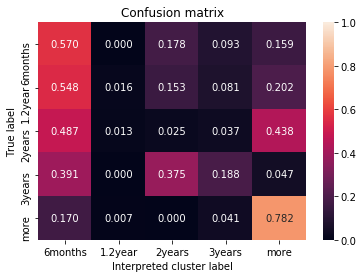

In [34]:
plt.figure()
evaluation.plot_confusion_matrix(cfm, norm=True, classes=labels)
plt.xlabel('Interpreted cluster label')
plt.show()

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(15,10))

ax[0].scatter(estimators_range, errors)
ax[0].set_ylabel('Log-loss error on validation set')
ax[0].set_xlabel('Number of estimators for Random Forest Classifier');

ax[1].scatter(estimators_range, accuracies)
ax[1].set_ylabel('Accuracies on validation set')
ax[1].set_xlabel('Number of estimators for Random Forest Classifier');

ax[2].scatter(estimators_range, roc_auc)
ax[2].set_ylabel('AUC on validation set')
ax[2].set_xlabel('Number of estimators for Random Forest Classifier');

## Stage 4: Miscellaneous
 * Grid Search done 
 * Decide on each hyperparameter what its value should be then mix the val and train together to do the prediction

In [ ]:
# Random forests n_estimators based on validation set
estimators_range = [100, 200, 300, 400, 500, 1000, 2000]
accuracies = []
errors = []
roc_auc = []
cm = []
l = np.array(labels)
i=0
for n_estimators in estimators_range:
    rfc=RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
            max_depth=80, max_features=3, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=3, min_samples_split=8,
            min_weight_fraction_leaf=0.0, n_estimators=n_estimators, n_jobs=1,
            oob_score=False, random_state=1233, verbose=0,
            warm_start=False)
    
    rfc.fit(X_train, Y_train)
    
    # Accuracy
    accuracies.append(rfc.score(X_test,Y_test)) 
    
    # XEntropy Error
    probas = rfc.predict_proba(X_test)
    y_pred = np.argmax(probas, axis=1)
    error = log_loss(Y_test,probas)
    errors.append(error)
    
    # Confusion matrix      
    cfm = confusion_matrix(Y_test, l[y_pred])
    cm.append(cfm)
    
    # ROC-AUC - needs fixing for multi class AUC. But fixing ASAP 
    Y_test_binary = label_binarize(Y_test, classes=labels)
    y_pred_binary = label_binarize(l[y_pred],classes =labels)
    auc_curve = evaluation.multi_class_auc(len(l),Y_test_binary,y_pred_binary)
    roc_auc.append(auc_curve)
    i+=1
    print("Logloss {} -- Random Forest Classifier with features = {}, max_depth = {}, estimators = {} -- {}/{}".format(error,rfc.max_features,rfc.max_depth,n_estimators,i,len(estimators_range)))

optimal_acc_index = np.argmax(accuracies)
optimal_err_index = np.argmin(errors)
n_estimators_optimal_accuracy = estimators_range[optimal_acc_index]
n_estimators_optimal_error = estimators_range[optimal_err_index]
optimal_acc = accuracies[optimal_acc_index]
optimal_err = errors[optimal_err_index]

print("Optimal Random Forest Classifier for {0} class problem has Score: {1} and Logloss {2}".format(len(labels),optimal_acc,optimal_err))

# Pick one of them for the final merged training - You can see 100 is pretty good even though you ran CV on 400.
# Should re-run CV with 100. 
print('Optimal number of estimators based on validation set: {}\n Accuracy on validation set: {:.3f}'.
    format(n_estimators_optimal_accuracy, optimal_acc))
      
print('Optimal number of estimators based on validation set: {}\n Log-Loss on validation set: {:.3f}'.
    format(n_estimators_optimal_error, optimal_err))

### Gradient Boosting similar to Random forests

In [ ]:
# Gradient Boosting classifiers based on validation/test
estimators_range = [100, 200, 300, 400, 500, 1000, 2000]
accuracies = []
errors = []
roc_auc = []
cm = []
l = np.array(labels)

for n_estimators in estimators_range:
    gbc = GradientBoostingClassifier(learning_rate= 0.03, 
                                     n_estimators=n_estimators,
                                     max_depth =30,                          
                                     random_state = 1123)
    gbc.fit(X_train, Y_train)
    
    # Accuracy
    accuracies.append(gbc.score(X_test,Y_test)) 
    
    # XEntropy Error
    probas = gbc.predict_proba(X_test)
    y_pred = np.argmax(probas, axis=1)
    errors.append(log_loss(Y_test,probas))
    
    # ROC-AUC or Confusion matrix      
    cfm = confusion_matrix(Y_test, l[y_pred])
    cm.append(cfm)

#n_estimators_optimal_accuracies = estimators_range[np.argmax(accuracies)]
#n_estimators_optimal_errors = estimators_range[np.argmin(errors)]

In [ ]:
# Feature importance in descending order
feat_order_ind = np.argsort(rf_ind.feature_importances_)[::-1] # In descending order
print('50 most important features in order of decreasing importance: \n{}'.
      format(train_A.drop(["imgId", "is_person"], axis=1).columns[feat_order_ind[0:50]]))

title = 'Learning Curves (NN with tuned hyperparameters)'    
estimator = nn01_opt # regressor with tuned hyperparameters 
plot_learning_curve(estimator, title, sine_X_train, sine_y_train, 
                    ylim=(-10., 0.), cv=5, n_jobs=-1, scoring='mean_squared_error')
plt.grid(True)
plt.show()

## Exporting data to a tree style graph for interpretation

In [ ]:
dot_data = tree.export_graphviz(dt, out_file=None, 
    feature_names= df_clean.drop(["life_expectancy_bin","life_expectancy"], axis=1).columns,  
    class_names = labels,  
    filled=True, rounded=True,  
    special_characters=True)
graph = graphviz.Source(dot_data)
graph
#To create a file do this:
#To create a file do this:
with open("tree.dot", 'w') as f:
     f = export_graphviz(dt, out_file=f,
                         feature_names = df_clean.drop(["life_expectancy_bin","life_expectancy"], axis=1).columns,  
                         class_names = labels,   
                         filled=True, rounded=True,  
                         special_characters=True)